(0.0, 20.0)

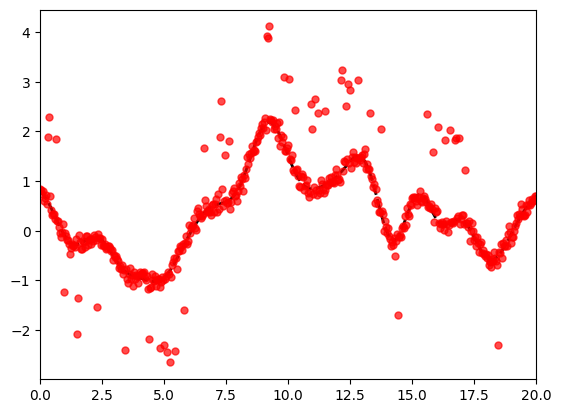

In [1]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

from numpy.lib.twodim_base import histogram2d
from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'chain_of_shift_of_softplus:0' shape=() dtype=float64, numpy=-4.600266525158521>)

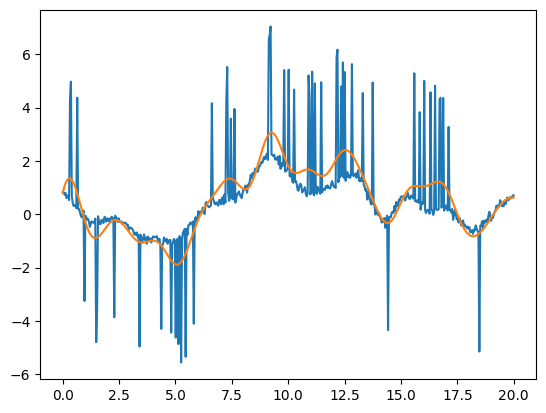

In [2]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)


f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)
plt.plot(x_obs,y_obs)

plt.plot(x_obs,f_mean)
standard_gp.trainable_variables

In [6]:
import gpflow
import tensorflow as tf
from gpflow.base import Parameter
from gpflow.kernels import Kernel
from gpflow.inducing_variables import InducingPoints
from gpflow.config import default_float
from gpflow.utilities import positive, print_summary
from gpflow.covariances import Kuu, Kuf
from gpflow.config import default_float, default_jitter
import w


def diag_matrix_from_vector(v):
    return tf.linalg.diag(v)



class GP_alpha(gpflow.models.BayesianModel):
    def __init__(self, kernel: Kernel, inducing_variable: InducingPoints,
                 alpha: float=0.5, sigma2: float=1):
        super().__init__()
        self.kernel = kernel
        self.inducing_variable = inducing_variable
        self.alpha = Parameter(alpha, transform=None,trainable=False)
        self.sigma2 = Parameter(sigma2,dtype=tf.float64,trainable=False)
 
 
 
    def maximum_log_likelihood_objective(self, data):
        return -self.compute_gvi_loss(data)
    
    def prediction(self,data):
        X, Y = data
        
        N = tf.shape(X)[0]
        
        K = self.kernel(X)
        K_uu = self.kernel(self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)
        N=X.shape[0]
        N_u=K_uu.shape[0]
         
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(N_u,dtype=tf.float64)*gpflow.default_jitter()
                               )

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        I=tf.linalg.eye(N,dtype=tf.float64)
        
        mu_f=self.alpha*Sigma_a@tf.linalg.inv(self.alpha*Sigma_a+I*self.sigma2)@(Y)
        return mu_f, Sigma_f

    def compute_gvi_loss(self, data):
        X, Y = data
        
        N = tf.shape(X)[0]
        
        K = self.kernel(X)
        K_uu = self.kernel(self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)
        N=X.shape[0]
        N_u=K_uu.shape[0]
        jitter=default_jitter()
         
        L_uu = tf.linalg.cholesky(K_uu + jitter)
        K_uu_inv_K_uf = tf.linalg.cholesky_solve(L_uu, K_uf)
        Sigma_f = tf.transpose(K_uf) @ K_uu_inv_K_uf

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        I=tf.linalg.eye(N,dtype=tf.float64)
        
        mu_f=self.alpha*Sigma_a@tf.linalg.inv(self.alpha*Sigma_a+I*self.sigma2)@(Y)
        
        
        term1=(0.5*tf.reduce_sum(tf.squeeze(Y-mu_f)**2/self.sigma2)+0.5*tf.math.log(self.sigma2))+0.5*tf.reduce_sum(tf.linalg.diag_part(Sigma_f)/self.sigma2)
        eye=tf.linalg.eye(N,dtype=tf.float64)*default_jitter()
        term2=0.5*(self.alpha*tf.transpose(mu_f)@tf.linalg.inv(Sigma_a+eye)@mu_f)+1/(1-self.alpha)*(
            tf.linalg.logdet(Sigma_a+eye)-(1-self.alpha)*tf.linalg.logdet(Sigma_f+eye)
             -self.alpha*tf.linalg.logdet(K+eye)
                )
        
        return term1 -term2 

N=x_obs.shape[0]
Z = x_obs[np.random.choice(N, 10, replace=False), :]
inducing_variable = Parameter(Z,trainable=False)
kernel(inducing_variable)

model = GP_alpha(kernel, inducing_variable,
                   alpha=0.5, sigma2=1)


model.compute_gvi_loss((x_obs,y_obs))


print_summary(model)

optimizer = gpflow.optimizers.Scipy()
loss_fn = lambda: model.maximum_log_likelihood_objective((x_obs, y_obs))
optimizer.minimize(loss_fn, variables=model.trainable_variables)






2025-06-10 20:16:15.863687: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-06-10 20:16:15.872932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.


InvalidArgumentError: {{function_node __wrapped__MatrixInverse_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is not invertible. [Op:MatrixInverse] name: 

In [4]:
print_summary(model)

╒══════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                         │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞══════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GP_alpha.kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 7.239758052771484e-10 │
├──────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GP_alpha.kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 42.91816              │
├──────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GP_alpha.inducing_variable   │ Parameter │ Identity    │         │ False       │ (10, 1) │ float64 │ [[3.8877

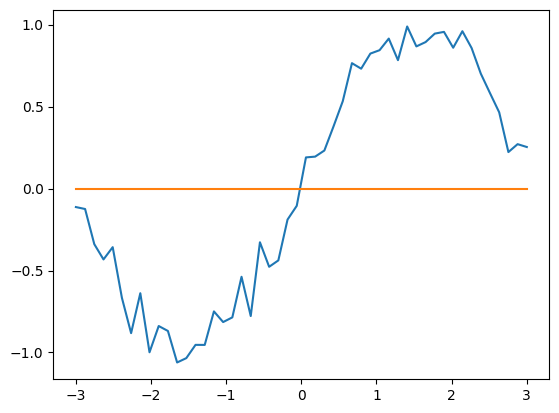

In [50]:
plt.plot(X,Y)
mu,sigma=model.prediction((X,Y))
plt.plot(X,mu)

In [52]:
import gpflow
import tensorflow as tf
from gpflow.base import Parameter
from gpflow.kernels import Kernel
from gpflow.inducing_variables import InducingPoints
from gpflow.config import default_float
from gpflow.utilities import positive, print_summary
from gpflow.covariances import Kuu, Kuf


def diag_matrix_from_vector(v):
    return tf.linalg.diag(v)


def jittered_cholesky_and_logdet(K, initial_jitter=1e-6, max_tries=5):
    jitter = initial_jitter
    for _ in range(max_tries):
        try:
            K_j = K + tf.eye(tf.shape(K)[0], dtype=K.dtype) * jitter
            L = tf.linalg.cholesky(K_j)
            logdet = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)))
            return L, logdet
        except tf.errors.InvalidArgumentError:
            jitter *= 10.0
    K_j = K + tf.eye(tf.shape(K)[0], dtype=K.dtype) * jitter
    L = tf.linalg.cholesky(K_j)
    logdet = 2.0 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L)))
    return L, logdet


class GeneralizedVariationalInferenceModel(gpflow.models.BayesianModel):
    def __init__(self, kernel: Kernel, inducing_variable: InducingPoints,
                 alpha: float=0.5, sigma2: float=0.1, nu: float=4):
        super().__init__()
        self.kernel = kernel
        self.inducing_variable = inducing_variable
        self.alpha = Parameter(alpha, transform=None,trainable=True)
        self.sigma2 = Parameter(sigma2, transform=positive(),trainable=False)
        self.nu = Parameter(nu, transform=positive(),trainable=False)

    def maximum_log_likelihood_objective(self, data):
        return -self.compute_gvi_loss(data)

    def update_posterior(self, X, Y):
        K = self.kernel(X)
        K_uu = self.kernel(self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        L_uu, logdet_K_uu = jittered_cholesky_and_logdet(K_uu)
        K_uu_inv = tf.linalg.cholesky_solve(L_uu, tf.eye(tf.shape(K_uu)[0], dtype=K_uu.dtype))

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f

        diag_Sigma_f = tf.linalg.diag_part(Sigma_f)
        resid = tf.squeeze(Y)#MISSING MU_F HERE
        denom = self.nu * self.sigma2 + tf.square(resid) + diag_Sigma_f
        V_inv_diag = tf.constant((self.nu + 1.0) / denom)

        V = diag_matrix_from_vector(1.0 / V_inv_diag)
        M = Sigma_a + V
        L_M, _ = jittered_cholesky_and_logdet(M)
        temp = tf.linalg.cholesky_solve(L_M, Y)
        mu_f = Sigma_a @ temp

        mu_logdet_V = tf.reduce_sum(tf.math.log(denom)) - tf.reduce_sum(tf.math.digamma(self.nu + 1.0))

        return mu_f, Sigma_f, K, Sigma_a, V_inv_diag, mu_logdet_V, logdet_K_uu

    def compute_gvi_loss(self, data):
        X, Y = data
        mu_f, Sigma_f, K, Sigma_a, V_inv_diag, mu_logdet_V, logdet_K_uu = self.update_posterior(X, Y)
        N = tf.shape(X)[0]

        resid = tf.squeeze(Y - mu_f)
        term1 = tf.reduce_sum(V_inv_diag * tf.square(resid))
        term2 = tf.reduce_sum(V_inv_diag * tf.linalg.diag_part(Sigma_f))
        term3 = mu_logdet_V

        # Mahalanobis via solve: μ_f^T Σ_a^{-1} μ_f
        L_a, logdet_Sigma_a = jittered_cholesky_and_logdet(Sigma_a)
        # Solve Σ_a^{-1} μ_f
        inv_mu = tf.linalg.cholesky_solve(L_a, mu_f)
        mahal = tf.squeeze(tf.matmul(tf.transpose(mu_f), inv_mu))
        term4 = (self.alpha / 2.0) * mahal

        _, logdet_Sigma_f = jittered_cholesky_and_logdet(Sigma_f)
        _, logdet_K = jittered_cholesky_and_logdet(K)
        log_det_term = logdet_Sigma_a - (1.0 - self.alpha) * logdet_Sigma_f - self.alpha * logdet_K
        term5 = -0.5 / (self.alpha - 1.0) * log_det_term

        return term1 + term2 + term3 + term4 + term5 - self.alpha * logdet_K_uu


if __name__ == "__main__":
    import numpy as np

    N = 50
    X = np.linspace(-3, 3, N).reshape(-1, 1)
    Y = np.sin(X) + 0.1 * np.random.randn(N, 1)

    kernel = gpflow.kernels.SquaredExponential()
    Z = X[np.random.choice(N, 10, replace=False), :]
    inducing_variable = Parameter(Z,trainable=False)

    model = GeneralizedVariationalInferenceModel(kernel, inducing_variable,
                                                alpha=0.5, sigma2=0.1, nu=2.0)
    print_summary(model)

    optimizer = gpflow.optimizers.Scipy()
    loss_fn = lambda: model.maximum_log_likelihood_objective((X, Y))
    optimizer.minimize(loss_fn, variables=model.trainable_variables)

    print_summary(model)


╒══════════════════════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                                                     │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞══════════════════════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GeneralizedVariationalInferenceModel.kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0                 │
├──────────────────────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GeneralizedVariationalInferenceModel.kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0                 │
├──────────────────────────────────────────────────────────┼───────────┼──────────

TypeError: in user code:

    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 192, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 329, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/1632623539.py", line 112, in None  *
        lambda: model.maximum_log_likelihood_objective((X, Y))
    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/1632623539.py", line 42, in maximum_log_likelihood_objective  *
        return -self.compute_gvi_loss(data)
    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/1632623539.py", line 73, in compute_gvi_loss  *
        mu_f, Sigma_f, K, Sigma_a, V_inv_diag, mu_logdet_V, logdet_K_uu = self.update_posterior(X, Y)
    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/1632623539.py", line 59, in update_posterior  *
        V_inv_diag = tf.constant((self.nu + 1.0) / denom)

    TypeError: Expected any non-tensor type, but got a tensor instead.


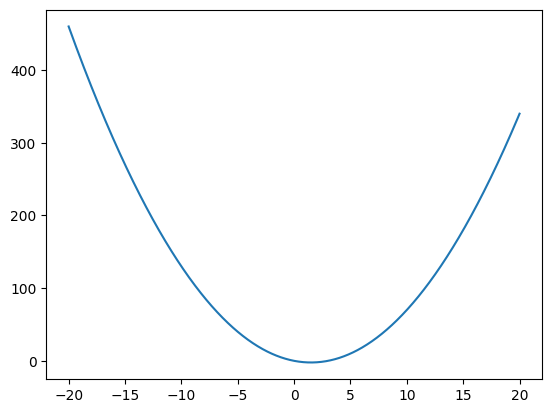

In [14]:
x=np.linspace(-20,20,1000)
y= (x)**2-x*3
import matplotlib.pyplot as plt
plt.plot(x,y)

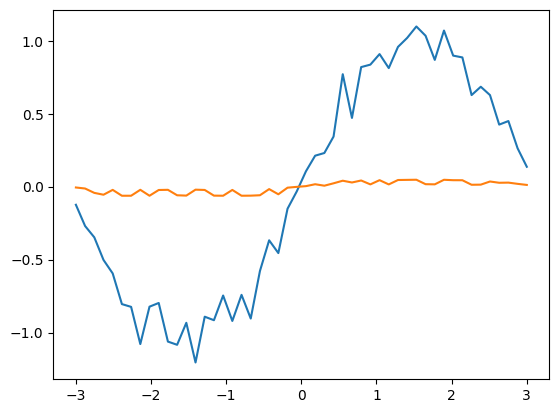

In [117]:
import gpflow
import tensorflow as tf
from gpflow.base import Parameter
from gpflow.kernels import Kernel
from gpflow.inducing_variables import InducingPoints
from gpflow.config import default_float
from gpflow.utilities import positive, print_summary
from gpflow.covariances import Kuu, Kuf
from gpflow.config import default_float, default_jitter
import w


def diag_matrix_from_vector(v):
    return tf.linalg.diag(v)



class RCGP_alpha(gpflow.models.BayesianModel):
    def __init__(self, kernel: Kernel, inducing_variable: InducingPoints,weightfunction,C,
                 alpha: float=0.5, sigma2: float=1):
        super().__init__()
        self.kernel = kernel
        self.inducing_variable = inducing_variable
        self.alpha = Parameter(alpha, transform=None,trainable=False)
        self.sigma2 = Parameter(sigma2,trainable=False)
        self.weightfunction = weightfunction(C=C)

    def maximum_log_likelihood_objective(self, data):
        return -self.compute_gvi_loss(data)
    
    
    def update_posterior(self, X, Y):
        K = self.kernel(X)
        K_uu = self.kernel(self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)
        
        W_y=self.weightfunction.W(X,Y)
        self.m_y=mw_y=self.weightfunction.dy(X,Y)**2
        
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, -2)))*self.sigma2
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, 2)))/self.sigma2
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(10,dtype=tf.float64)*gpflow.default_jitter()
                               )

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        
        mu_f=self.alpha*Sigma_a@tf.linalg.inv(self.alpha*Sigma_a+J_w)@(Y-mw_y)
        self.sigma2.assign(tf.reduce_sum(tf.transpose(Y-mu_f-mw_y)@J_w_inv@(Y-mu_f-mw_y)/tf.reduce_sum(J_w_inv)))
        #self.sigma2.assign(tf.reduce_mean(Y**2))
        return mu_f, Sigma_f, K, Sigma_a,J_w_inv

    def compute_gvi_loss(self, data):
        X, Y = data
        
        N = tf.shape(X)[0]
        
        mu_f, Sigma_f, K, Sigma_a,J_w_inv=self.update_posterior(X, Y)

        term1=(-tf.transpose(mu_f)@J_w_inv@mu_f
               -tf.linalg.trace(Sigma_f@J_w_inv)
               +2*tf.transpose(mu_f)@J_w_inv@(Y-self.m_y))
        eye=tf.linalg.eye(N,dtype=tf.float64)*default_jitter()
        term2=(self.alpha*tf.transpose(mu_f)@tf.linalg.inv(Sigma_a+eye)@mu_f)+1/(1-self.alpha)*(
            tf.linalg.logdet(Sigma_a+eye)-(1-self.alpha)*tf.linalg.logdet(Sigma_f+eye)
             -self.alpha*tf.linalg.logdet(K+eye)
                )
        
        
        return -term1 -term2 

if __name__ == "__main__":
    import numpy as np

    N = 50
    X = np.linspace(-3, 3, N).reshape(-1, 1)
    Y = np.sin(X) + 0.1 * np.random.randn(N, 1)

    kernel = gpflow.kernels.SquaredExponential()
    Z = X[np.random.choice(N, 10, replace=False), :]
    inducing_variable = Parameter(Z,trainable=True)
    kernel(inducing_variable)

    model = RCGP_alpha(kernel, inducing_variable,
                       alpha=0.5, sigma2=1,weightfunction=w.IMQ,C=0.95)
    

    model.compute_gvi_loss((X,Y))


    print_summary(model)

    optimizer = gpflow.optimizers.Scipy()
    loss_fn = lambda: model.maximum_log_likelihood_objective((X, Y))
    optimizer.minimize(loss_fn, variables=model.trainable_variables)

    print_summary(model)


╒════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                           │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ RCGP_alpha.kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0                 │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ RCGP_alpha.kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0                 │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ RCGP_alpha.inducing_variable   │ Parameter │ Identity    │         │ True        │ (10, 1) │ float64 │ [[-1.4

2025-05-26 20:56:54.156641: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-05-26 20:56:54.156687: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-05-26 20:56:54.157414: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-05-26 20:56:54.157467: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-05-26 20:56:54.158105: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

HERE WE COMPUTE THE MARGINAL

In [ ]:
import gpflow
import tensorflow as tf
from gpflow.base import Parameter
from gpflow.kernels import Kernel
from gpflow.inducing_variables import InducingPoints
from gpflow.config import default_float
from gpflow.utilities import positive, print_summary
from gpflow.covariances import Kuu, Kuf
from gpflow.config import default_float, default_jitter
import w


def diag_matrix_from_vector(v):
    return tf.linalg.diag(v)



class RCGP_alpha(gpflow.models.BayesianModel):
    def __init__(self, kernel: Kernel, inducing_variable: InducingPoints,weightfunction,C,
                 alpha: float=0.5, sigma2: float=1):
        super().__init__()
        self.kernel = kernel
        self.inducing_variable = inducing_variable
        self.alpha = Parameter(alpha, transform=None,trainable=False)
        self.sigma2 = Parameter(sigma2,trainable=True)
        self.weightfunction = weightfunction(C=C)

    def maximum_log_likelihood_objective(self, data):
        return -self.compute_gvi_loss(data)
    
    
    def update_posterior(self, X, Y):
        K = self.kernel(X)
        K_uu = self.kernel(self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)
        
        W_y=self.weightfunction.W(X,Y)
        self.m_y=mw_y=self.weightfunction.dy(X,Y)**2
        
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, -2)))*self.sigma2
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, 2)))/self.sigma2
        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(10,dtype=tf.float64)*gpflow.default_jitter()
                               )

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        
        mu_f=Sigma_a@tf.linalg.inv(Sigma_a+J_w)@(Y-mw_y)
        self.sigma2.assign(tf.reduce_sum(tf.transpose(Y-mu_f-mw_y)@J_w_inv@(Y-mu_f-mw_y)/tf.reduce_sum(J_w_inv)))
        #self.sigma2.assign(tf.reduce_mean(Y**2))
        return mu_f, Sigma_f, K, Sigma_a,J_w_inv

    def compute_pred_loss(self):
        X, Y = data
        
        N = tf.shape(X)[0]
        
        mu_f, Sigma_f, K, Sigma_a,J_w_inv=self.update_posterior(X, Y)
        VAR=Sigma_f+self.sigma2*tf.linalg.eye(N,dtype=tf.float64)
        VAR=(tf.linalg.eye(N,dtype=tf.float64)-mu_f)
        term1=(-tf.transpose(mu_f)@J_w_inv@mu_f
               #-tf.linalg.trace(Sigma_f@J_w_inv)
               +2*tf.transpose(mu_f)@J_w_inv@(Y-self.m_y))
        eye=tf.linalg.eye(N,dtype=tf.float64)*default_jitter()
        term2=(self.alpha*tf.transpose(mu_f)@tf.linalg.inv(Sigma_a+eye)@mu_f)
        """      +1/(1-self.alpha)*(
            tf.linalg.logdet(Sigma_a+eye)-(1-self.alpha)*tf.linalg.logdet(Sigma_f+eye)
             -self.alpha*tf.linalg.logdet(K+eye)
                ))
        """
        
        return -term1 +term2 

if __name__ == "__main__":
    import numpy as np

    N = 50
    X = np.linspace(-3, 3, N).reshape(-1, 1)
    Y = np.sin(X) + 0.1 * np.random.randn(N, 1)

    kernel = gpflow.kernels.SquaredExponential()
    Z = X[np.random.choice(N, 10, replace=False), :]
    inducing_variable = Parameter(Z,trainable=True)
    kernel(inducing_variable)

    model = RCGP_alpha(kernel, inducing_variable,
                       alpha=0.5, sigma2=1,weightfunction=w.IMQ,C=0.95)
    

    model.compute_gvi_loss((X,Y))


    print_summary(model)

    optimizer = gpflow.optimizers.Scipy()
    loss_fn = lambda: model.maximum_log_likelihood_objective((X, Y))
    optimizer.minimize(loss_fn, variables=model.trainable_variables)

    print_summary(model)


In [110]:
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class RCGP_tf(gpflow.Module):
    def __init__(self, X, Y, J_w, J_w_inv, m_w, *,
                 init_sigma=0.01,
                 init_c_f=1.0,
                 init_variance=4.5,
                 init_lengthscale=0.9,
                 init_alpha=0.5,
                 dtype=tf.float64):
        super().__init__(name="RCGP_tf")
        self.dtype = dtype

        # Data + weight matrices
        self.X = tf.convert_to_tensor(X, dtype=dtype)
        self.Y = tf.convert_to_tensor(Y, dtype=dtype)
        self.J_w = tf.convert_to_tensor(J_w, dtype=dtype)
        self.J_w_inv = tf.convert_to_tensor(J_w_inv, dtype=dtype)
        self.m_w = tf.convert_to_tensor(m_w, dtype=dtype)

        # Constrained variables
        clip = lambda z: tf.clip_by_value(z, 0.001, 10.0)
        self.sigma = tf.Variable(init_sigma, dtype=dtype, constraint=clip)
        self.c_f = tf.Variable(init_c_f, dtype=dtype, constraint=clip)
        self.variance = tf.Variable(init_variance, dtype=dtype, constraint=clip)
        self.lengthscale = tf.Variable(init_lengthscale, dtype=dtype, constraint=clip)

        clip_alpha = lambda a: tf.clip_by_value(a, -1.0, 2.0)
        self.alpha = tf.Variable(init_alpha, dtype=dtype, constraint=clip_alpha)

    @staticmethod
    def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma2, Y, m_w):
        A = alpha * Sigma_a_inv + 2.0 * J_w_inv / sigma2
        b = tf.matmul(2.0 * J_w_inv / sigma2, (Y - m_w))
        return tf.linalg.solve(A, b)

    def _compute_posterior(self):
        """
        Internal: compute mu_f and Sigma_f using current hyperparameters.
        Returns
        -------
        mu_f : tf.Tensor[N, 1]
        Sigma_f : tf.Tensor[N, N]
        """
        jitter = gpflow.config.default_jitter()
        N = tf.shape(self.X)[0]
        I = tf.eye(N, dtype=self.dtype) * jitter

        # Kernel matrix
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.sqrt(self.variance),
            length_scale=self.lengthscale)
        K = tf.cast(kernel.matrix(self.X, self.X), self.dtype)

        # Sigma_f
        mix = self.sigma**2 / 2.0
        K_tilde = K + mix * self.J_w + I
        Sigma_f = self.c_f * (K @ tf.linalg.inv(K_tilde) @ (mix * self.J_w))

        # mu_f
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + I)
        mu_f = self.update_mu_f(self.alpha, Sigma_a_inv,
                                self.J_w_inv, self.sigma**2,
                                self.Y, self.m_w)
        return mu_f, Sigma_f

    def gvi_loss(self):
        mu_f, Sigma_f = self._compute_posterior()
        jitter = gpflow.config.default_jitter()
        N = tf.shape(self.X)[0]
        I = tf.eye(N, dtype=self.dtype) * jitter

        # Data-fit terms
        term1 = 0.5 * tf.transpose(mu_f) @ self.J_w_inv @ mu_f / (self.sigma**2)
        term2 = -    tf.transpose(mu_f) @ self.J_w_inv @ (self.Y - self.m_w) / (self.sigma**2)
        term3 = 0.5 * tf.linalg.trace(self.J_w_inv @ Sigma_f) / (self.sigma**2)
        data_fit = term1 + term2 + term3

        # Complexity term via slogdet
        _, logdet_a = tf.linalg.slogdet(
            self.alpha * K + (1.0 - self.alpha) * Sigma_f + I)
        _, logdet_f = tf.linalg.slogdet(Sigma_f + I)
        _, logdet_k = tf.linalg.slogdet(K + I)
        complexity = -1.0 / (2.0 * (1 - self.alpha)) * (
            logdet_a + (self.alpha - 1.0) * logdet_f - self.alpha * logdet_k)

        return tf.squeeze(data_fit + complexity)

    @property
    def trainable_variables(self):
        return [self.sigma, self.c_f, self.variance, self.lengthscale, self.alpha]

    def train(self, compile: bool = True, **scipy_kwargs):
        optimizer = gpflow.optimizers.Scipy()
        loss_fn = lambda: self.gvi_loss()
        optimizer.minimize(loss_fn,
                           variables=self.trainable_variables,
                           compile=compile,
                           **scipy_kwargs)
        tf.print("Optimization complete.")

    def predict_posterior(self):
        """
        Return posterior mean and covariance (mu_f, Sigma_f) after training.
        """
        return self._compute_posterior()

# Example:
# model = RCGP_tf(X, Y, J_w, J_w_inv, m_w)
# model.train(method="l-bfgs-b", options={"maxiter":100})
# mu_f, Sigma_f = model.predict_posterior()

# -----------------------------
# Example usage:
# -----------------------------
import numpy as np

# toy data
N = 50
X = np.linspace(-3, 3, N).reshape(-1,1)
Y = np.sin(X) + 0.1*np.random.randn(N,1)

# build weights as in your script
w_full = np.random.rand(N,1)+0.1
J_w     = np.diagflat((w_full**-2).squeeze())
J_w_inv = np.diagflat((w_full** 2).squeeze())
m_w_full = np.zeros_like(Y)

model = RCGP_tf(X, Y, J_w, J_w_inv, m_w_full)
model.train()

print_summary(model)

Optimization complete.
╒═════════════════════╤══════════════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                │ class            │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════╪══════════════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ RCGP_tf.sigma       │ ResourceVariable │             │         │ True        │ ()      │ float64 │ 0.000200658 │
├─────────────────────┼──────────────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ RCGP_tf.c_f         │ ResourceVariable │             │         │ True        │ ()      │ float64 │ 1           │
├─────────────────────┼──────────────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ RCGP_tf.variance    │ ResourceVariable │             │         │ True        │ ()      │ float64 │ 4.5         │
├─────────────────────┼──────────────────┼─────────────┼─

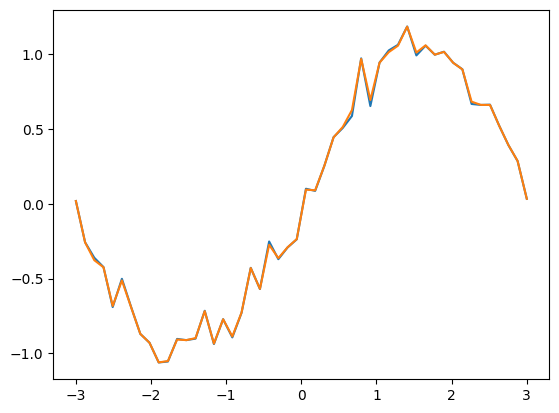

In [111]:
mu,sigma=model.predict_posterior()
plt.plot(X,Y)
plt.plot(X,mu)

In [115]:
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors

class RCGP_tf(gpflow.Module):
    def __init__(self, X, Y, J_w, J_w_inv, m_w, *,
                 init_sigma=0.01,
                 init_c_f=1.0,
                 init_variance=4.5,
                 init_lengthscale=0.9,
                 init_alpha=0.5,
                 dtype=tf.float64):
        super().__init__(name="RCGP_tf")
        self.dtype = dtype

        # Data + weight matrices
        self.X = tf.convert_to_tensor(X, dtype=dtype)
        self.Y = tf.convert_to_tensor(Y, dtype=dtype)
        self.J_w = tf.convert_to_tensor(J_w, dtype=dtype)
        self.J_w_inv = tf.convert_to_tensor(J_w_inv, dtype=dtype)
        self.m_w = tf.convert_to_tensor(m_w, dtype=dtype)

        # Constrained variables
        clip = lambda z: tf.clip_by_value(z, 0.001, 10.0)
        self.sigma = tf.Variable(init_sigma, dtype=dtype, constraint=clip)
        self.c_f = tf.Variable(init_c_f, dtype=dtype, constraint=clip)
        self.variance = tf.Variable(init_variance, dtype=dtype, constraint=clip)
        self.lengthscale = tf.Variable(init_lengthscale, dtype=dtype, constraint=clip)

        clip_alpha = lambda a: tf.clip_by_value(a, -1.0, 2.0)
        self.alpha = tf.Variable(init_alpha, dtype=dtype, constraint=clip_alpha)

    @staticmethod
    def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma2, Y, m_w):
        A = alpha * Sigma_a_inv + 2.0 * J_w_inv / sigma2
        b = tf.matmul(2.0 * J_w_inv / sigma2, (Y - m_w))
        return tf.linalg.solve(A, b)

    def gvi_loss(self):
        # jitter for numerical stability
        jitter = gpflow.config.default_jitter()
        N = tf.shape(self.X)[0]
        I = tf.eye(N, dtype=self.dtype) * jitter

        # 1) TFP RBF kernel
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
            amplitude=tf.sqrt(self.variance),
            length_scale=self.lengthscale)
        K = tf.cast(kernel.matrix(self.X, self.X), self.dtype)

        # 2) Sigma_f with jitter
        mix = self.sigma**2 / 2.0
        K_tilde = K + mix * self.J_w + I
        Sigma_f = self.c_f * (K @ tf.linalg.inv(K_tilde) @ (mix * self.J_w))

        # 3) Sigma_a and its inverse with jitter
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + I)

        # 4) mu_f using stable update
        mu_f = self.update_mu_f(self.alpha, Sigma_a_inv,
                                self.J_w_inv, self.sigma**2,
                                self.Y, self.m_w)

        # 5) data-fit terms
        term1 = 0.5 * tf.transpose(mu_f) @ self.J_w_inv @ mu_f / (self.sigma**2)
        term2 = -    tf.transpose(mu_f) @ self.J_w_inv @ (self.Y - self.m_w) / (self.sigma**2)
        term3 = 0.5 * tf.linalg.trace(self.J_w_inv @ Sigma_f) / (self.sigma**2)
        data_fit = term1 + term2 + term3

        # 6) complexity term via slogdet for stability
        _, logdet_a = tf.linalg.slogdet(Sigma_a + I)
        _, logdet_f = tf.linalg.slogdet(Sigma_f + I)
        _, logdet_k = tf.linalg.slogdet(K + I)
        complexity = -1.0/(2.0*(1-self.alpha)) * (
            logdet_a + (self.alpha - 1.0)*logdet_f - self.alpha*logdet_k)

        return tf.squeeze(data_fit + complexity)

    @property
    def trainable_variables(self):
        return [self.sigma, self.c_f, self.variance, self.lengthscale, self.alpha]

    def train(self, learning_rate=0.01, steps=1000):
        opt = tf.keras.optimizers.Adam(learning_rate)
        for i in range(steps):
            with tf.GradientTape() as tape:
                loss = self.gvi_loss()
            grads = tape.gradient(loss, self.trainable_variables)
            opt.apply_gradients(zip(grads, self.trainable_variables))
            if i % 100 == 0:
                # Use tf.print without f-strings for ResourceVariables
                tf.print("Step", i,
                         "loss=", loss,
                         "σ=", self.sigma,
                         "c_f=", self.c_f,
                         "var=", self.variance,
                         "ls=", self.lengthscale,
                         "α=", self.alpha)

# Example usage omitted for brevity
import numpy as np

# toy data
N = 50
X = np.linspace(-3, 3, N).reshape(-1,1)
Y = np.sin(X) + 0.1*np.random.randn(N,1)

# build weights as in your script
w_full = np.random.rand(N,1)+0.1
J_w     = np.diagflat((w_full**-2).squeeze())
J_w_inv = np.diagflat((w_full** 2).squeeze())
m_w_full = np.zeros_like(Y)

model = RCGP_tf(X, Y, J_w, J_w_inv, m_w_full)
model.train()

print_summary(model)




Step 0 loss= -77539.172369216671 σ= 0.001 c_f= 0.99000007085851338 var= 4.50999991996459 ls= 0.89000006717131852 α= 0.49000006758479614
Step 100 loss= -7817772.1495415336 σ= 0.001 c_f= 1.503228581967468 var= 5.0147232786154508 ls= 0.41729490492148558 α= 0.0048853327186146
Step 200 loss= -7817776.085948294 σ= 0.001 c_f= 1.3923609251701592 var= 5.071233243769278 ls= 0.40433459045529618 α= 0.0069257516701252634
Step 300 loss= -7817782.1044688653 σ= 0.001 c_f= 1.2328371013194077 var= 5.14920966916491 ls= 0.38429446423683716 α= 0.0071715835343792184
Step 400 loss= -7817792.5815343494 σ= 0.001 c_f= 1.0242572010927811 var= 5.2495889298537453 ls= 0.353948617419991 α= 0.0079965278022895471
Step 500 loss= -7817816.5325791491 σ= 0.001 c_f= 0.75550702793015256 var= 5.3823117505728817 ls= 0.30129450117730178 α= 0.011487344518090801
Step 600 loss= -7817925.4049057346 σ= 0.001 c_f= 0.356613432748081 var= 5.575097624406423 ls= 0.18645499099973861 α= 0.040405541329832255
Step 700 loss= -7818015.3928213

In [3]:
standard_gp = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.SquaredExponential(),
)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(standard_gp.training_loss_closure(), variables=standard_gp.trainable_variables)

f_mean, f_var = standard_gp.predict_f(X, full_cov=False)

f_std = np.sqrt(f_var)
standard_gp.trainable_parameters

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.9335701014673088>,
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.1689166696137183>,
 <Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.008308072027597351>)

In [95]:
import gpflow
import tensorflow as tf
from gpflow.base import Parameter
from gpflow.kernels import Kernel
from gpflow.inducing_variables import InducingPoints
from gpflow.config import default_jitter
from gpflow.utilities import positive, print_summary
import w


def _update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma2, Y, m_w):
    A = alpha * Sigma_a_inv + 2.0 * J_w_inv / sigma2
    b = tf.matmul(2.0 * J_w_inv / sigma2, (Y - m_w))
    return tf.linalg.solve(A, b)


class RCGP_alpha(gpflow.models.BayesianModel):
    def __init__(self,
                 kernel: Kernel,
                 data,
                 inducing_variable: InducingPoints = None,
                 weightfunction=None,
                 C: float = 0.95,
                 alpha: float = 0.5,
                 sigma2: float = 1.0,
                 method: str = "c_f"):
        super().__init__()
        self.X, self.Y = data
        self.kernel = kernel
        self.method = method
        self.alpha = Parameter(alpha, transform=None, trainable=False)
        self.sigma2 = tf.constant(sigma2,dtype=tf.float64)
        self.weightfunction = weightfunction(C=C)

        W_y = self.weightfunction.W(self.X, self.Y)
        self.m_w = self.weightfunction.dy(self.X, self.Y) ** 2
        self.J_w = tf.linalg.diag(tf.squeeze(W_y ** -2))
        self.J_w_inv = tf.linalg.diag(tf.squeeze(W_y ** 2))

        if method == "c_f":
            self.c_f = Parameter(1.0, transform=positive(), trainable=True)
        else:
            if inducing_variable is None:
                raise ValueError("Inducing variables required for inducing method.")
            self.inducing_variable = inducing_variable

    def maximum_log_likelihood_objective(self):
        return -self.compute_marginal()#-self.compute_gvi_loss()

    def update_posterior_2(self):
        # Increase jitter multiplier for robust inverses
        base_jitter = default_jitter()
        jitter = base_jitter * 10.0
        N = tf.shape(self.X)[0]
        I_K = tf.eye(N, dtype=tf.float64) * jitter  # for kernel
        I_A = tf.eye(N, dtype=tf.float64) * jitter  # for Sigma_a

        K = self.kernel(self.X)
        # Ensure dtype match
        K = tf.cast(K, tf.float64)

        # Weighted posterior covariance
        mix = (self.sigma2 / 2.0)
        inv_term = tf.linalg.inv(K + mix * self.J_w + I_K)
        Sigma_f = self.c_f * (K @ inv_term @ (mix * self.J_w))

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + I_A)

        mu_f = _update_mu_f(self.alpha, Sigma_a_inv, self.J_w_inv, self.sigma2, self.Y, self.m_w)
        return mu_f, Sigma_f, K, Sigma_a, Sigma_a_inv

    def compute_gvi_loss(self):
        if self.method == "c_f":
            mu_f, Sigma_f, K, Sigma_a, _ = self.update_posterior_2()
        else:
            raise NotImplementedError("Inducing update not yet adapted.")

        # Standard jitter for slogdet
        jitter = default_jitter()
        N = tf.shape(self.X)[0]
        I = tf.eye(N, dtype=tf.float64) * jitter

        _, logdet_a = tf.linalg.slogdet(Sigma_a + I)
        _, logdet_f = tf.linalg.slogdet(Sigma_f + I)
        _, logdet_k = tf.linalg.slogdet(K + I)

        df1 = 0.5 * tf.transpose(mu_f) @ self.J_w_inv @ mu_f / self.sigma2
        df2 = -1*tf.transpose(mu_f) @ self.J_w_inv @ (self.Y - self.sigma2*self.m_w) / self.sigma2
        df3 = 0.5 * tf.linalg.trace(self.J_w_inv @ Sigma_f) / self.sigma2
        data_fit =  df1+df2+df3

        complexity =  -(1.0 / (2.0 * (1.0 - self.alpha))) * (
            logdet_a + (self.alpha - 1.0) * logdet_f - self.alpha * logdet_k
        )

        return tf.squeeze(data_fit + complexity)
    def compute_marginal(self):
        mu_f, Sigma_f, K, Sigma_a, Sigma_a_inv = self.update_posterior_2()
        VAR=self.J_w_inv@tf.linalg.inv(Sigma_a_inv+self.J_w_inv/self.sigma2)@self.J_w_inv/self.sigma2**2
        jitter = default_jitter()
        N=self.X.shape[0]
        dist=tfp.distributions.MultivariateNormalFullCovariance(tf.zeros_like(tf.squeeze(self.Y)), VAR+tf.eye(N, dtype=tf.float64) * jitter)
        return dist.log_prob(tf.squeeze(self.Y))

if __name__ == "__main__":
    import numpy as np
    N = 50
    X = np.linspace(-3, 3, N).reshape(-1, 1)
    Y = np.sin(X) + 0.1 * np.random.randn(N, 1)

    kernel = gpflow.kernels.SquaredExponential()
    Z = X[np.random.choice(N, 10, replace=False), :]
    inducing_variable = InducingPoints(Z)

    model = RCGP_alpha(
        kernel=kernel,
        data=(X, Y),
        inducing_variable=inducing_variable,
        weightfunction=w.IMQ,
        C=0.95,
        alpha=0.5,
        sigma2=1.0,
        method="c_f"
    )

    print_summary(model)
    print("Trainables:", [v.name for v in model.trainable_variables])
    lower, upper = 1e-3, 1e2
    import tensorflow_probability as tfp
    tfb = tfp.bijectors

    lower = tf.constant(1e-3, dtype=tf.float64)
    upper = tf.constant(10.0, dtype=tf.float64)

    # Define a bijector that maps real numbers to [lower, upper]
    bounded_bijector = tfb.Chain([
        tfb.Shift(shift=lower),         # shift from [0, upper-lower] to [lower, upper]
        tfb.Scale(scale=upper - lower), # scale sigmoid output
        tfb.Sigmoid(),                  # squashes real line to (0,1)
    ])


    # Apply bounded transform to GPflow parameter
    model.kernel.variance = gpflow.Parameter(1.0, transform=bounded_bijector,dtype=tf.float64)
    model.kernel.lengthscales = gpflow.Parameter(1.0, transform=bounded_bijector,dtype=tf.float64)
    print(model.maximum_log_likelihood_objective())


    opt = gpflow.optimizers.Scipy()
    opt.minimize(lambda: model.maximum_log_likelihood_objective(), model.trainable_variables)

    print_summary(model)
    print("Optimized:", [v.name for v in model.trainable_variables])


╒════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                           │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ RCGP_alpha.kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ RCGP_alpha.kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │    1    │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ RCGP_alpha.alpha               │ Parameter │ Identity    │         │ False       │ ()      │ float64 │    0.5  │
├────────────────────────────────┼───────────┼─────────────┼─────────┼──────────

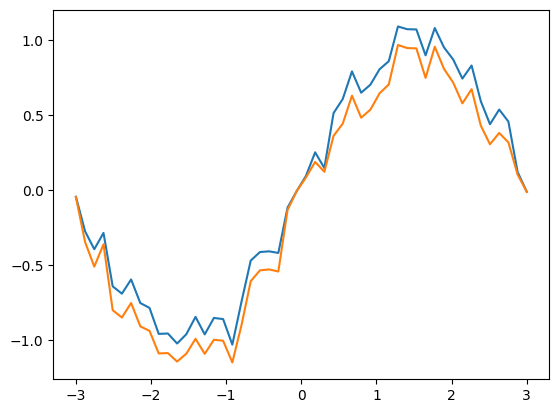

In [96]:
import matplotlib.pyplot as plt
mu_f, Sigma_f, K, Sigma_a,Sigma_a_inv=model.update_posterior_2()
plt.plot(X,Y)
plt.plot(X,mu_f)
#plt.plot(X,f_mean)

In [73]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=8255.595577845364>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=4.797996099742924>,
 <tf.Variable 'chain_of_shift_of_scale_of_sigmoid:0' shape=() dtype=float64, numpy=-11.053537651465366>,
 <tf.Variable 'chain_of_shift_of_scale_of_sigmoid:0' shape=() dtype=float64, numpy=75.73853126914149>)

In [31]:
    print_summary(model)

╒════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                           │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ RCGP_alpha.kernel.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1         │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ RCGP_alpha.kernel.lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1         │
├────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ RCGP_alpha.alpha               │ Parameter │ Identity    │         │ False       │ ()      │ float64 │ 0.5       │
├────────────────────────────────┼───────────┼─────────────┼────

In [6]:
kernel = gpflow.kernels.SquaredExponential()
Z = x_obs[np.random.choice(N, 10, replace=False), :]
inducing_variable = Parameter(Z,trainable=False)


model = RCGP_alpha(kernel, inducing_variable,
                       alpha=0.5, sigma2=0.3,weightfunction=w.IMQ,C=np.quantile(abs(y_obs),0.9))
optimizer = gpflow.optimizers.Scipy()
loss_fn = lambda: model.maximum_log_likelihood_objective((x_obs, y_obs))
optimizer.minimize(loss_fn, variables=model.trainable_variables)

mu_f, Sigma_f, K, Sigma_a,J_w_inv=model.update_posterior_2(x_obs,y_obs)
plt.plot(x_obs,y_obs)
plt.plot(x_obs,mu_f)
model.trainable_variables

NameError: name 'x_obs' is not defined

In [5]:
import my_class
standard_gp = my_class.Robust_gaussian_base_class(
    (x_obs, y_obs),
    weighting_function=w,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

#f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
print(standard_gp.trainable_variables)
opt_options
res = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)
print(res)
"""
gpflow.utilities.print_summary(standard_gp, "notebook")"""

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-0.43275212956718856>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'chain_of_shift_of_softplus:0' shape=() dtype=float64, numpy=-4.600266525158521>)


NotImplementedError: in user code:

    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 192, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 329, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/integration/tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/models/training_mixins.py", line 64, in training_loss  *
        return self._training_loss()  # type: ignore[attr-defined]
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/integration/tf.py", line 69, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/models/model.py", line 76, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())
    File "/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/my_class.py", line 85, in maximum_log_likelihood_objective  *
        return self.training_GVI()
    File "/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/my_class.py", line 195, in training_GVI  *
        c = self.maximize_c(y, self.prop)
    File "/Users/piergiacomocarlesi/PycharmProjects/LOSS_OPT/my_class.py", line 168, in maximize_c  *
        return np.quantile(abs(y), 1 - quant)
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/numpy/lib/function_base.py", line 4536, in quantile  **
        a = np.asanyarray(a)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (Abs:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [7]:
import my_class_2
X=tf.cast(X,tf.float64)
y=tf.cast(y,tf.float64)


standard_gp = my_class_2.Robust_gaussian_base_class(
    X, y,
    weighting_function=w,
    kernel=tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale),
    noise_variance=sigma_n**2
)

#f_mean, f_var = standard_gp.predict_f(x, full_cov=False)
"""
opt = gpflow.optimizers.Scipy()
opt_options = dict()
print(standard_gp.trainable_variables)

res = opt.minimize(training_GVI, standard_gp.trainable_variables, options=opt_options)
print(res)"""

10


'\nopt = gpflow.optimizers.Scipy()\nopt_options = dict()\nprint(standard_gp.trainable_variables)\nopt_options\nres = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)\nprint(res)'

In [8]:
opt = gpflow.optimizers.Scipy()
opt_options = dict()
print(standard_gp.trainable_variables)

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-0.43275212956718856>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'chain_of_shift_of_softplus:0' shape=() dtype=float64, numpy=-4.600266525158521>)


In [11]:
res = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)

ValueError: in user code:

    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 192, in _tf_eval  *
        loss, grads = _compute_loss_and_gradients(
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 329, in _compute_loss_and_gradients  *
        loss = loss_closure()
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/integration/tf.py", line 57, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/models/training_mixins.py", line 64, in training_loss  *
        return self._training_loss()  # type: ignore[attr-defined]
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/integration/tf.py", line 69, in wrapped_method  *
        return wrapped_function(self, *args, **kwargs)
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/check_shapes/decorator.py", line 121, in wrapped_function  *
        if not get_enable_check_shapes():
    File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/models/model.py", line 76, in _training_loss  *
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())

    ValueError: None values not supported.


THIS IS THE FIRST PROPOSED MODEL, CORRESPONDING TO THE RCGP-alpha

In [43]:

@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 2 * J_w_inv / sigma_2)
    q2 = tf.matmul((2 * J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)



def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    #update quantitites, Sigma_a,J_w
    w_full = sigma / (2 ** 0.5) * w_full
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2))) * sigma ** 2 / 2
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2))) * 2 / (sigma ** 2)

    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)

    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full)
    return (mu_f, Sigma_f)



import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2



sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

import tensorflow_probability as tfp

for i in range(500):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.1)
        n_test = X_test.shape[0]
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)

        new_ind = list(train_indices.numpy())
        #update quantitites, Sigma_a,J_w
        w_train = tf.gather(w_full, train_indices)
        m_w = tf.gather(m_w_full, train_indices)
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w)
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K) @ mu_f
        sigma_f_pred = K_star_star
        sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K + sigma ** 2 * J_w) @ K_star
        sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K) @ K_star + tf.linalg.eye(
            n_test, dtype=tf.float64) * sigma**2
        sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
        vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(Y_test)
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))

Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

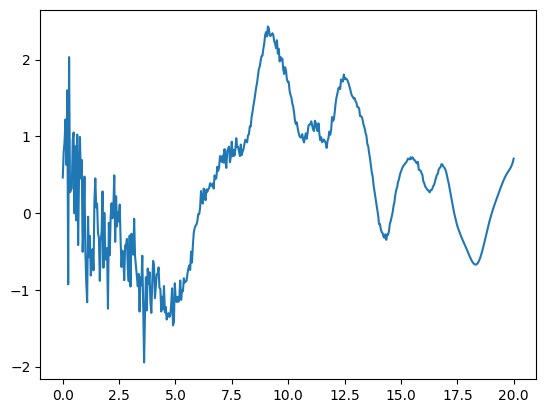

In [46]:
plt.plot(X,Mu_full)

HERE I MAXIMIZE WITH RESPECT TO WEIGHTED PREDICTIVE

In [62]:

@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 2 * J_w_inv / sigma_2)
    q2 = tf.matmul((2 * J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)



def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    #update quantitites, Sigma_a,J_w
    w_full = sigma / (2 ** 0.5) * w_full
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))

    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)

    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full)
    return (mu_f, Sigma_f)



import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2



sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

import tensorflow_probability as tfp

for i in range(500):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.1)
        n_test = X_test.shape[0]
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)

        new_ind = list(train_indices.numpy())
        #update quantitites, Sigma_a,J_w
        w_train = tf.gather(w_full, train_indices)
        m_w = tf.gather(m_w_full, train_indices)
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w)
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K) @ mu_f
        sigma_f_pred = K_star_star
        sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K + sigma ** 2 * J_w) @ K_star
        sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K) @ K_star + tf.linalg.eye(
            n_test, dtype=tf.float64) * sigma**2
        sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)*tf.gather(w_full, test_indices)**(2)
        vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(Y_test)
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))

Mu_full_2, Sigma_full_2 = Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

this is with minimizing the GVI objective instead of PREDICTIVE.



In [164]:
@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv +  J_w_inv / sigma_2)
    q2 = tf.matmul(( J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)

sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

import tensorflow_probability as tfp

J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2)))
J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2)))
m_w=m_w_full
for i in range(2000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, y, m_w)
        eye=tf.linalg.eye(X.shape[0], dtype=tf.float64)*0.000001
        print(0.5*sigma**(-2)*tf.transpose(mu_f)@J_w_inv@mu_f-sigma**(-2)*tf.transpose(mu_f)@J_w_inv@(y-m_w)+alpha/2*tf.transpose(mu_f)@Sigma_a_inv @mu_f)
        loss = 0.5*sigma**(-2)*tf.transpose(mu_f)@J_w_inv@mu_f-sigma**(-2)*tf.transpose(mu_f)@J_w_inv@(y-m_w)+alpha/2*tf.transpose(mu_f)@Sigma_a_inv @mu_f+0.5*sigma**(-2)*tf.linalg.trace(J_w_inv@Sigma_f)
        -1/(2*(alpha-1))*tf.math.log(tf.linalg.det(Sigma_a+eye)*tf.linalg.det(Sigma_f+eye)**(alpha-1)*tf.linalg.det(K+eye)**(-alpha))
    sigma=tf.transpose(y-mu_f-m_w)@J_w_inv@(y-mu_f-m_w)/tf.reduce_sum(J_w_inv)
    sigma=tf.sqrt(sigma)
    grad = tape.gradient(loss, [c_f, variance, lengthscale, alpha])
    optimizer = tf.optimizers.()
    optimizer.apply_gradients(zip(grad, [c_f, variance, lengthscale, alpha]))


SyntaxError: invalid syntax (1350281215.py, line 42)

THIS IS WHERE IM GONNA START FROM TOMORROW.


In [165]:
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow

@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + J_w_inv / sigma_2)
    q2 = tf.matmul(J_w_inv / sigma_2, (Y_train - mu_w))
    return tf.matmul(q1, q2)

# Parameters with transforms
variance = gpflow.Parameter(4.5, transform=gpflow.utilities.positive())
lengthscale = gpflow.Parameter(0.9, transform=gpflow.utilities.positive())
c_f = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
# transform for alpha in (-1,2)
alpha = gpflow.Parameter(0.5,trainable=False)

# Data

sigma = 0.01

# Precompute weight-related matrices
W = w.IMQ(c_f)
w_full = tf.cast(W.W(X, y), tf.float64)
J_w = tf.linalg.diag(tf.squeeze(w_full**-2))
J_w_inv = tf.linalg.diag(tf.squeeze(w_full**2))
m_w = W.dy(X, y)**2


# Helper for stable solves
@tf.function
def stable_solve(mat, rhs):
    jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
    L = tf.linalg.cholesky(mat + jitter)
    return tf.linalg.cholesky_solve(L, rhs)

@tf.function
def compute_loss():
    # Kernel
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    N = tf.shape(K)[0]
    identity = tf.eye(N, dtype=K.dtype)
    # Covariances with jitter
    jitter = identity * 1e-6
    K_j = K + jitter

    # Sigma_f via solve
    Sigma_f = c_f * K @ stable_solve(K_j + (sigma**2)/2 * J_w, (sigma**2)/2 * J_w)
    # Blend to Sigma_a
    Sigma_a = alpha * K_j + (1.0 - alpha) * Sigma_f

    # Compute mu_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma**2, y, m_w)

    # Log-determinants
    ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
    ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
    ld_K = tf.linalg.logdet(K_j)

    # Loss terms
    term1 = 0.5 * sigma**(-2) * tf.transpose(mu_f) @ J_w_inv @ mu_f
    term2 = -sigma**(-2) * tf.transpose(mu_f) @ J_w_inv @ (y - m_w)
    term3 = (alpha / 2.0) * tf.transpose(mu_f) @ Sigma_a_inv @ mu_f
    term4 = 0.5 * sigma**(-2) * tf.linalg.trace(J_w_inv @ Sigma_f)
    term5 = -1.0 / (2.0 * (alpha - 1.0)) * (ld_Sig_a + (alpha - 1.0) * ld_Sig_f - alpha * ld_K)


    return tf.squeeze(term1 + term2 + term3 + term4 + term5)

# Gather tf.Variables for optimization
variables = []
for p in [variance, lengthscale, c_f, alpha]:
    variables += p.trainable_variables

opt = gpflow.optimizers.Scipy()
opt.minimize(compute_loss, variables=variables)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -869021.9457252846
        x: [ 1.547e+00 -4.787e+00  1.841e+00]
      nit: 8
      jac: [-5.833e-03 -5.344e-02  1.021e-02]
     nfev: 16
     njev: 16
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [3]:
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

# --- Define trainable parameters as gpflow.Parameter ---
variance = gpflow.Parameter(4.5, transform=gpflow.utilities.positive())
lengthscale = gpflow.Parameter(0.9, transform=gpflow.utilities.positive())
c_f = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
alpha = gpflow.Parameter(0.5, trainable=False)

# --- Mutable sigma ---
sigma = tf.Variable(0.01, dtype=tf.float64)

# --- Helper function for stable solves ---
@tf.function
def stable_solve(mat, rhs):
    jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
    L = tf.linalg.cholesky(mat + jitter)
    return tf.linalg.cholesky_solve(L, rhs)

# --- mu_f computation helper ---
@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + J_w_inv / sigma_2)
    q2 = tf.matmul(J_w_inv / sigma_2, (Y_train - mu_w))
    return tf.matmul(q1, q2)

# --- Training step ---
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        N = tf.shape(K)[0]
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        # Sigma_f and Sigma_a
        Sigma_f = c_f * K @ stable_solve(K_j + (sigma**2)/2 * J_w, (sigma**2)/2 * J_w)
        Sigma_a = alpha * K_j + (1.0 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma**2, y, m_w)

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K_j)

        # Loss terms
        term1 = 0.5 * sigma**(-2) * tf.transpose(mu_f) @ J_w_inv @ mu_f
        term2 = -sigma**(-2) * tf.transpose(mu_f) @ J_w_inv @ (y - m_w)
        term3 = (alpha / 2.0) * tf.transpose(mu_f) @ Sigma_a_inv @ mu_f
        term4 = 0.5 * sigma**(-2) * tf.linalg.trace(J_w_inv @ Sigma_f)
        term5 = -1.0 / (2.0 * (alpha - 1.0)) * (ld_Sig_a + (alpha - 1.0) * ld_Sig_f - alpha * ld_K)
        loss = tf.squeeze(term1 + term2 + term3 + term4 + term5)

    # Compute gradients and apply them
    trainables = []
    for p in [variance, lengthscale, c_f]:
        trainables.extend(p.trainable_variables)
    grads = tape.gradient(loss, trainables)
    optimizer.apply_gradients(zip(grads, trainables))

    # Update sigma using current mu_f
    residual = y - mu_f - m_w
    num = tf.transpose(residual) @ J_w_inv @ residual
    denom = tf.reduce_sum(J_w_inv)
    sigma.assign(tf.squeeze(tf.sqrt(num / denom)))


    return loss, sigma

# --- Optimizer ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# --- Run training ---
# --- Convergence configuration ---
max_steps = 1000
tolerance = 0.01
patience = 10  # number of steps with minimal loss change before stopping

# History trackers
loss_history = []
best_loss = float("inf")
steps_without_improvement = 0

for step in range(max_steps):
    loss_val, sigma_val = train_step()
    loss_val = loss_val.numpy()  # for float comparison
    loss_history.append(loss_val)

    # Print progress
    tf.print("Step:", step, "Loss:", loss_val, "Sigma:", sigma_val)

    # Check convergence
    if step > 0:
        loss_diff = abs(loss_history[-1] - loss_history[-2])
        if loss_diff < tolerance:
            steps_without_improvement += 1
        else:
            steps_without_improvement = 0

        if steps_without_improvement >= patience:
            print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
            break



NameError: in user code:

    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_3007/646309499.py", line 40, in train_step  *
        Sigma_f = c_f * K @ stable_solve(K_j + (sigma**2)/2 * J_w, (sigma**2)/2 * J_w)

    NameError: name 'J_w' is not defined


In [178]:
update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma**2, y, m_w)
plt.plot(X,y_obs)
plt.plot(np.linspace(0,20,200),mu_f)

ValueError: in user code:

    File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2211/646309499.py", line 24, in update_mu_f  *
        q1 = tf.linalg.inv(alpha * Sigma_a_inv + J_w_inv / sigma_2)

    ValueError: Dimensions must be equal, but are 200 and 500 for '{{node add}} = AddV2[T=DT_DOUBLE](mul, truediv)' with input shapes: [200,200], [500,500].


In [132]:
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class CustomGPModel(gpflow.models.BayesianModel):
    def __init__(self, X, y, J_w, J_w_inv, m_w, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y
        self.J_w = J_w
        self.J_w_inv = J_w_inv
        self.m_w = m_w
        self.alpha = gpflow.Parameter(0.5,trainable=False)

        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.c_f = gpflow.Parameter(1.0, transform=gpflow.utilities.positive())

        # sigma is not a Parameter, but a mutable tf.Variable
        self.sigma = tf.Variable(1., dtype=tf.float64)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    @tf.function
    def update_mu_f(self, Sigma_a_inv, sigma_2):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + self.J_w_inv / sigma_2)
        q2 = tf.matmul(self.J_w_inv / sigma_2, self.y - self.m_w)
        return tf.matmul(q1, q2)
    def maximum_log_likelihood_objective(self):
        pass
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            N = tf.shape(K)[0]
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            Sigma_f = self.c_f * K @ self.stable_solve(K_j + (self.sigma**2)/2 * self.J_w, (self.sigma**2)/2 * self.J_w)
            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2)

            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = 0.5 * self.sigma**(-2) * tf.transpose(mu_f) @ self.J_w_inv @ mu_f
            term2 = -self.sigma**(-2) * tf.transpose(mu_f) @ self.J_w_inv @ (self.y - self.m_w)
            term3 = (self.alpha / 2.0) * tf.transpose(mu_f) @ Sigma_a_inv @ mu_f
            term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(self.J_w_inv @ Sigma_f)
            term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2 + term3 + term4 + term5)

        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))

        # Update sigma using current mu_f
        residual = self.y - mu_f - self.m_w
        num = tf.transpose(residual) @ self.J_w_inv @ residual
        denom = tf.reduce_sum(self.J_w_inv)
        self.sigma.assign(tf.squeeze(tf.sqrt(num / denom)))

        return loss, self.sigma
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        N = tf.shape(K)[0]
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Sigma_f = self.c_f * K @ self.stable_solve(K_j + (self.sigma**2) * self.J_w, (self.sigma**2) * self.J_w)
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2)
        return mu_f,Sigma_f

    def train(self, max_steps=1000, tolerance=0.5, patience=5):
        loss_history = []
        steps_without_improvement = 0

        for step in range(max_steps):
            loss_val, sigma_val = self.train_step()
            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val, "Sigma:", sigma_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
                    
# Precompute weight-related matrices
W = w.IMQ(c_f)
w_full = tf.cast(W.W(X, y), tf.float64)
J_w = tf.linalg.diag(tf.squeeze(w_full**-2))
J_w_inv = tf.linalg.diag(tf.squeeze(w_full**2))
m_w = W.dy(X, y)**2
model = CustomGPModel(X, y, J_w, J_w_inv, m_w)
model.train()

Step: 0 Loss: 146.34301947968163 Sigma: 0.35893889657036726
Step: 1 Loss: -288.1991337843324 Sigma: 0.34611300571389458
Step: 2 Loss: -327.1488774263134 Sigma: 0.34586177244551924
Step: 3 Loss: -328.11352480643814 Sigma: 0.3457714892190426
Step: 4 Loss: -328.5601975306737 Sigma: 0.34568598035823755
Step: 5 Loss: -328.9877282921442 Sigma: 0.3456040409274882
Step: 6 Loss: -329.39960422824447 Sigma: 0.34552596320860668
Step: 7 Loss: -329.79466905254094 Sigma: 0.34545186994569932
Step: 8 Loss: -330.17240441294416 Sigma: 0.34538178152484283
Early stopping at step 8: loss change < 0.5 for 5 steps.


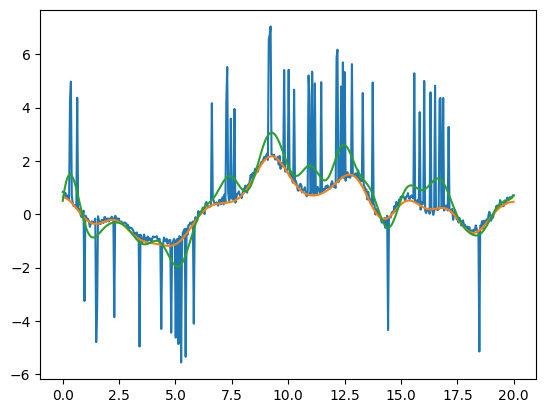

In [133]:
mu_f,sigma_f=model.predict()
plt.plot(X,y)
plt.plot(X,mu_f)
plt.plot(X,f_mean)

In [15]:
     
        
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class CustomGPModel(gpflow.models.BayesianModel):
    def __init__(self, X, y, J_w, J_w_inv, m_w,inducing, alpha=0.5):
        super().__init__()
        self.X = X
        self.y = y
        self.J_w = J_w
        self.J_w_inv = J_w_inv
        self.m_w = m_w
        self.alpha = gpflow.Parameter(0.5,trainable=False)

        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing

        # sigma is not a Parameter, but a mutable tf.Variable
        self.sigma = tf.Variable(1., dtype=tf.float64)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    @tf.function
    def update_mu_f(self, Sigma_a_inv, sigma_2):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + self.J_w_inv / sigma_2)
        q2 = tf.matmul(self.J_w_inv / sigma_2, self.y - self.m_w)
        return tf.matmul(q1, q2)
    def maximum_log_likelihood_objective(self):
        pass
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)

            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

            Sigma_f = K_fu @ K_uu_inv @ K_uf
            N = tf.shape(K)[0]
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            
            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2)

            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = 0.5 * self.sigma**(-2) * tf.transpose(mu_f) @ self.J_w_inv @ mu_f
            term2 = -self.sigma**(-2) * tf.transpose(mu_f) @ self.J_w_inv @ (self.y - self.m_w)
            term3 = (self.alpha / 2.0) * tf.transpose(mu_f) @ Sigma_a_inv @ mu_f
            term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(self.J_w_inv @ Sigma_f)
            term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2 + term3 + term4 + term5)

        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))

        # Update sigma using current mu_f
        residual = self.y - mu_f - self.m_w
        num = tf.transpose(residual) @ self.J_w_inv @ residual
        denom = tf.reduce_sum(self.J_w_inv)
        self.sigma.assign(tf.squeeze(tf.sqrt(num / denom)))

        return loss, self.sigma
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        N = tf.shape(K)[0]
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2)
        return mu_f,Sigma_f

    def train(self, max_steps=1000, tolerance=0.5, patience=5):
        loss_history = []
        steps_without_improvement = 0

        for step in range(max_steps):
            loss_val, sigma_val = self.train_step()
            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val, "Sigma:", sigma_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
                    
# Precompute weight-related matrices
W = w.IMQ(2.5)
w_full = tf.cast(W.W(X, y), tf.float64)
J_w = tf.linalg.diag(tf.squeeze(w_full**-2))
J_w_inv = tf.linalg.diag(tf.squeeze(w_full**2))
m_w = W.dy(X, y)**2
N=X.shape[0]
Z = X[np.random.choice(N, 40, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = CustomGPModel(X, y, J_w, J_w_inv, m_w,inducing_variable)
model.train()

Step: 0 Loss: 251.23700614481947 Sigma: 0.64622550548591329
Step: 1 Loss: 315.42792791528177 Sigma: 0.64341407392302519
Step: 2 Loss: 310.0653762442562 Sigma: 0.64348440383687089
Step: 3 Loss: 303.6759916018659 Sigma: 0.64351181483911168
Step: 4 Loss: 297.32466259867186 Sigma: 0.64349306537222783
Step: 5 Loss: 291.020867210485 Sigma: 0.64344421857308731
Step: 6 Loss: 284.7668793726403 Sigma: 0.64337605866600722
Step: 7 Loss: 278.5673348858913 Sigma: 0.64329554358812513
Step: 8 Loss: 272.4288596391909 Sigma: 0.64320731417042032
Step: 9 Loss: 266.35839031941435 Sigma: 0.64311466615120649
Step: 10 Loss: 260.36237710605394 Sigma: 0.64302015219732922
Step: 11 Loss: 254.44692377482795 Sigma: 0.64292600742368056
Step: 12 Loss: 248.61725608774987 Sigma: 0.6428344946112764
Step: 13 Loss: 242.87651236850712 Sigma: 0.64274814770312383
Step: 14 Loss: 237.22531831535144 Sigma: 0.64266985016795852
Step: 15 Loss: 231.66195208366378 Sigma: 0.64260270010219345
Step: 16 Loss: 226.18275658197115 Sigma: 0

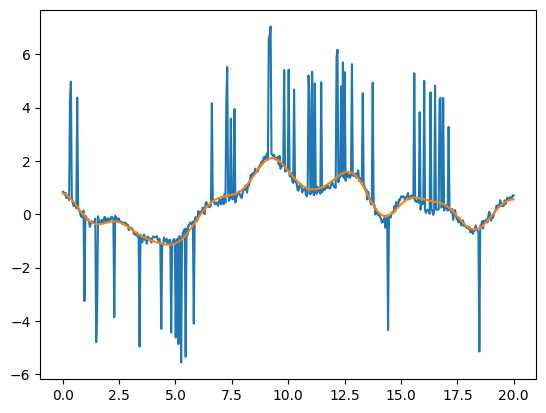

In [16]:
mu_f_1,sigma_f=model.predict()
plt.plot(X,y)
#plt.plot(X,mu_f)
plt.plot(X,mu_f_1)

In [26]:
upper=2*tf.squeeze(tf.linalg.diag_part(sigma_f))+tf.squeeze(mu_f)+2*model.sigma
#upper=upper+[2.,]*500*model.sigma
lower=-2*tf.squeeze(tf.linalg.diag_part(sigma_f))+tf.squeeze(mu_f)-2*model.sigma

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.01>

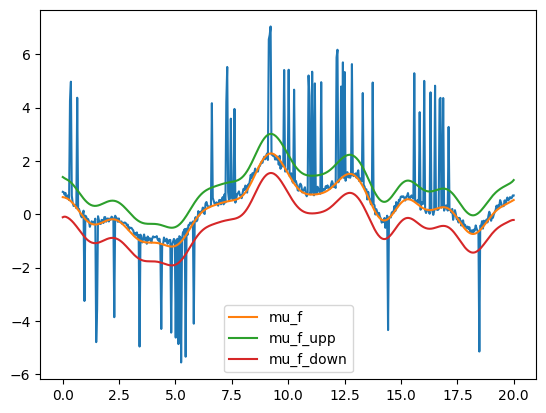

In [27]:
plt.plot(x,y)
plt.plot(x,mu_f,label='mu_f')
sigma_f=tf.squeeze(tf.linalg.diag_part(sigma_f))

plt.plot(x,upper,label='mu_f_upp')
plt.plot(x,lower,label='mu_f_down')
#plt.plot(x[0:20],Mu_full[0:20],label='mu_full')
#plt.plot(x[0:20],Mu_full_2[0:20],label='mu_full_2')
#plt.plot(x,f_mean,label='f_mean')
plt.legend()

sigma

In [165]:
class RCPGG_alpha_pred(gpflow.models.BayesianModel):
    def __init__(self, X, y,weightfunction,C):
        super().__init__()
        self.X = X
        self.Y= y

        self.weightfunction = weightfunction(C=C)

        self.w_full = self.weightfunction.W(self.X, self.Y)
        self.m_w_full = self.weightfunction.dy(self.X, self.Y) ** 2
        # GP parameters
        self.alpha = gpflow.Parameter(0.5,trainable=False)
        self.variance = gpflow.Parameter(0.1, transform=gpflow.utilities.positive())

        self.lengthscale = gpflow.Parameter(0.1, transform=gpflow.utilities.positive())
        self.c_f = gpflow.Parameter(0.1, transform=gpflow.utilities.positive())
        self.sigma = gpflow.Parameter(.34)#, transform=gpflow.utilities.positive())
        self.X_train, self.Y_train, self.X_test, self.Y_test, self.train_indices, self.test_indices = self.divide_batch()

    
    def update_mu_f(self, Sigma_a_inv, J_w_inv, Y, mu_w):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + J_w_inv / self.sigma**2)
        q2 = tf.matmul((J_w_inv / self.sigma**2), (Y - mu_w))
        return tf.matmul(q1, q2)
    
    
    def divide_batch(self, test_ratio=0.2):
        
        seed = np.random.uniform(0, 1000)
    
        random.seed(seed)
    
        # Get the number of samples
        n = tf.shape(self.X)[0]
        num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)
    
        # Shuffle indices
        indices = tf.range(n)
        shuffled_indices = tf.random.shuffle(indices)
    
        # Split indices
        test_indices = shuffled_indices[:num_test]
        train_indices = shuffled_indices[num_test:]
    
        # Split data
        X_train = tf.gather(self.X, train_indices)
        X_test = tf.gather(self.X, test_indices)
        Y_train = tf.gather(self.Y, train_indices)
        Y_test = tf.gather(self.Y, test_indices)
        return X_train, Y_train, X_test, Y_test, train_indices, test_indices
    
    
    def Full_sample_estimate(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        N = tf.shape(K)[0]
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(self.w_full, -2))) 
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(self.w_full, 2)))

        Sigma_f = self.c_f * K @ tf.linalg.inv(K_j + (self.sigma**2)/2 *J_w)@  J_w*(self.sigma**2)/2 
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = self.update_mu_f( Sigma_a_inv, J_w_inv, self.Y, self.m_w_full)
        return mu_f,Sigma_f
    
    
    def pred_loss(self):
            n_test = self.X_test.shape[0]
            #estimate Gpflow kernel.
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X_train, self.X_train)
    

            #update quantitites, Sigma_a,J_w
            w_train = tf.gather(self.w_full, self.train_indices)
            m_w = tf.gather(self.m_w_full, self.train_indices)
            J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
            J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))
    
            Sigma_f = (self.c_f * K @ tf.linalg.inv(K + self.sigma ** 2 * J_w) * self.sigma ** 2) @ J_w
    
            Sigma_a = self.alpha * K + (1 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a)
    
            mu_f = self.update_mu_f( Sigma_a_inv, J_w_inv, self.Y_train, m_w)
            K_star = tf.transpose(kernel.matrix(self.X_test, self.X_train))
            K_star_star = kernel.matrix(self.X_test, self.X_test)
            n_train=self.X_train.shape[0]
            eye_n=tf.linalg.eye(n_train,dtype=tf.float64)
            
            mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(Sigma_f+eye_n) @ mu_f
            sigma_f_pred = K_star_star
            K_inv=tf.linalg.inv(K)
            sigma_f_pred = sigma_f_pred# - tf.transpose(K_star) @ K_inv @ K_star
            sigma_f_pred = sigma_f_pred - tf.transpose(K_star) @K_inv@Sigma_f@ K_inv@ K_star# + tf.linalg.eye(
                #n_test, dtype=tf.float64) * self.sigma**2
            sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)
            vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
            return -tf.reduce_mean(vv.log_prob(self.Y_test))
            #return tf.reduce_mean((mu_f_pred-tf.squeeze(self.Y_test))**2)
    def maximum_log_likelihood_objective(self):
        pass

model_1=RCPGG_alpha_pred(X,y,w.IMQ,2.)


optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model_1.pred_loss, variables=model_1.trainable_variables)


muu1,sigmaa=model_1.Full_sample_estimate()


2025-05-28 17:58:18.254496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input is not invertible.
	 [[{{node MatrixInverse_4}}]]


InvalidArgumentError: Graph execution error:

Detected at node MatrixInverse_4 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 640, in run_forever

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once

  File "/opt/homebrew/Cellar/python@3.12/3.12.8/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/138598288.py", line 111, in <module>

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 159, in minimize

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py", line 713, in minimize

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_lbfgsb_py.py", line 309, in _minimize_lbfgsb

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 402, in _prepare_scalar_function

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 166, in __init__

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 262, in _update_fun

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 163, in update_fun

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py", line 145, in fun_wrapped

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 78, in __call__

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py", line 72, in _compute_if_needed

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 224, in _eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 190, in _tf_eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 192, in _tf_eval

  File "/Users/piergiacomocarlesi/Downloads/RCGP-main/venv/lib/python3.12/site-packages/gpflow/optimizers/scipy.py", line 329, in _compute_loss_and_gradients

  File "/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_2238/68624617.py", line 96, in pred_loss

Input is not invertible.
	 [[{{node MatrixInverse_4}}]] [Op:__inference__tf_eval_2990609]

In [152]:

print(model.trainable_variables)
print(model_1.trainable_variables)


(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.6314362660447306>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.4527229976730551>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.34538178152484283>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.45546082634701973>)
(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.6314>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.45199999999999996>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.34>, <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.45400000000000007>)


In [168]:
model_1=RCPGG_alpha_pred(X,y,w.IMQ,2.)
adam_opt = tf.optimizers.Adam(learning_rate=0.01)
for i in range(500):
    with tf.GradientTape() as tape:
        loss = model_1.pred_loss()

    grads = tape.gradient(loss, model_1.trainable_variables)
    adam_opt.apply_gradients(zip(grads, model_1.trainable_variables))

#optimizer = gpflow.optimizers.Scipy()
#optimizer.minimize(lambda: model.pred_loss(), variables=model.trainable_variables)

In [169]:
model_1.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-2.5687854879284275>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-1.987478203553514>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.026331992097730732>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-1.4257986144213115>)

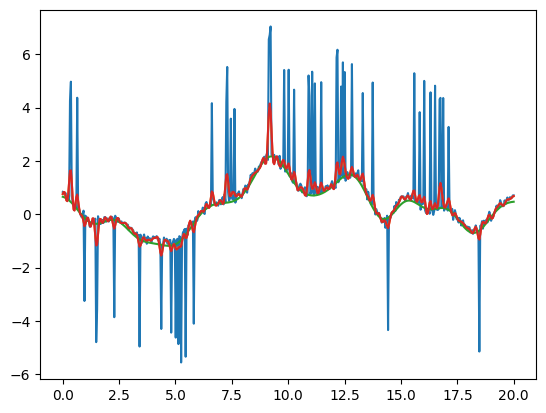

In [170]:
muu,sigmaa=model_1.Full_sample_estimate()
plt.plot(x_obs,y_obs)
plt.plot(X,muu)
plt.plot(x_obs,mu_f)
plt.plot(x_obs,muu1)

In [139]:
model.trainable_variables

(<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.6314362660447306>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.4527229976730551>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.34538178152484283>,
 <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=0.45546082634701973>)

In [144]:
model_1.c_f.assign(0.63)
model_1.c_f

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.63>

In [65]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_T(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5,nu=2):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable=False)

        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(1., transform=gpflow.utilities.positive())
        
        self.nu=tf.constant(nu,dtype=tf.float64)
        self.lambda_inv=tf.Variable([1.]*X.shape[0],trainable=False,dtype=tf.float64)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    
    @tf.function
    def update_mu_f(self, Sigma_a_inv, sigma_2,Lambda_inv):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + Lambda_inv / sigma_2)
        q2 = tf.matmul(Lambda_inv / sigma_2, self.y)
        return tf.matmul(q1, q2)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)

            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

            Sigma_f = K_fu @ K_uu_inv @ K_uf
            
            N = tf.cast(tf.shape(K)[0],tf.float64)
            print(N.dtype)
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            Lambda_inv=tf.linalg.diag(self.lambda_inv)
            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)

            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = 0.5 * self.sigma**(-2) * tf.transpose(mu_f) @ (Lambda_inv+Sigma_a_inv) @ mu_f
            term2 = -self.sigma**(-2) * tf.transpose(mu_f) @Lambda_inv @ (self.y)
            term3 = N* tf.math.log(self.sigma)
            term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Lambda_inv @ Sigma_f)
            term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2  + term3 + term4 + term5)

        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))

        # Update Lambda using current mu_f
        residual = self.y - mu_f
        num=self.nu+1
        denom=self.nu+tf.squeeze(residual)**2+tf.linalg.diag_part(Sigma_f)
        self.lambda_inv.assign(tf.squeeze((num / denom)))
         
        return loss
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        N = tf.cast(tf.shape(K)[0],tf.float64)
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Lambda_inv=tf.linalg.diag(self.lambda_inv)
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)
        return mu_f,Sigma_f

    def train(self, max_steps=500, tolerance=0.5, patience=5):
        loss_history = []
        steps_without_improvement = 0
        start_time = time.time()

        for step in range(max_steps):
            loss_val = self.train_step()
            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Training completed in {elapsed:.3f} seconds.")      

N=X.shape[0]
Z = X[np.random.choice(N, 70, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_T(X, y,inducing_variable)
model.train()

<dtype: 'float64'>
<dtype: 'float64'>
Step: 0 Loss: 15641.701943484128
Step: 1 Loss: 15802.972712000414
Step: 2 Loss: 15798.540454603593
Step: 3 Loss: 15786.52131930857
Step: 4 Loss: 15773.644800345272
Step: 5 Loss: 15760.589716203589
Step: 6 Loss: 15747.4004180469
Step: 7 Loss: 15734.073352069174
Step: 8 Loss: 15720.60232563602
Step: 9 Loss: 15706.98140703315
Step: 10 Loss: 15693.205286347225
Step: 11 Loss: 15679.270157458548
Step: 12 Loss: 15665.171717921661
Step: 13 Loss: 15650.907975705019
Step: 14 Loss: 15636.476017270781
Step: 15 Loss: 15621.873149040288
Step: 16 Loss: 15607.09564306678
Step: 17 Loss: 15592.138576302945
Step: 18 Loss: 15576.997025891842
Step: 19 Loss: 15561.665388894158
Step: 20 Loss: 15546.137825627497
Step: 21 Loss: 15530.407898722773
Step: 22 Loss: 15514.468216953886
Step: 23 Loss: 15498.309856423231
Step: 24 Loss: 15481.922854021945
Step: 25 Loss: 15465.297041073552
Step: 26 Loss: 15448.422993176162
Step: 27 Loss: 15431.292563632249
Step: 28 Loss: 15413.90167

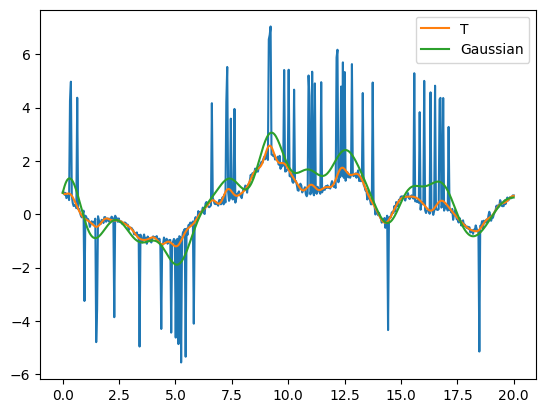

In [66]:
mu,s=model.predict()
plt.plot(X,y)
plt.plot(X,mu,label="T")
plt.plot(x_obs,f_mean,label="Gaussian")
plt.legend()
plt.show()


In [68]:
model.alpha
#model.sigma

<Parameter: name=identity, dtype=float64, shape=[], fn="identity", numpy=0.99>

In [37]:
kernel = gpflow.kernels.SquaredExponential()

# Define Student-t likelihood
likelihood = gpflow.likelihoods.StudentT(df=3.0)

# Define model
model = gpflow.models.VGP(data=(X, y), kernel=kernel, likelihood=likelihood)

# Optimize
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000))



NameError: name 'print_summary' is not defined

In [38]:


# Predict
Xtest = np.linspace(0, 20, 500).reshape(-1, 1)
Xtest = tf.convert_to_tensor(Xtest, dtype=tf.float64)
mean, var = model.predict_f(Xtest)

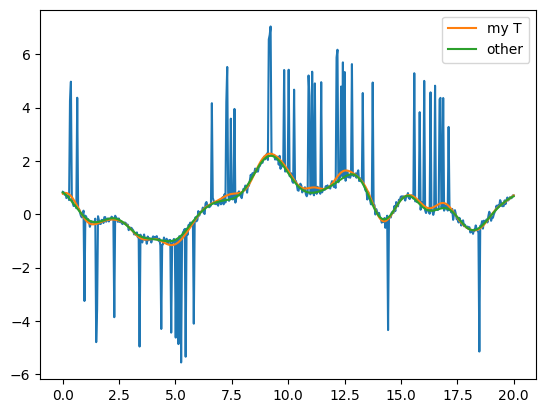

In [64]:
plt.plot(X,y)
plt.plot(X,mu,label="my T")
plt.plot(X,mean,label="other")
plt.legend()
plt.show()

tf.Tensor(0.00159780640183641, shape=(), dtype=float64)


In [23]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_WELSCH(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5,c_prop=2.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable=False)
        self.c=tf.Variable(c_prop*tf.reduce_mean(self.y**2),dtype=tf.float64)
        self.c_prop=c_prop
        
        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.mu_f = tf.Variable(tf.ones(self.y.shape, dtype=tf.float64))
        #self.mu_f=tf.reshape(self.mu_f, [-1, 1])
        print(self.mu_f.shape)
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)

            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

            Sigma_f = K_fu @ K_uu_inv @ K_uf
            sigma_f=tf.linalg.diag_part(Sigma_f)
            
            N = tf.cast(tf.shape(K)[0],tf.float64)
            print(N.dtype)
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            
            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = tf.reduce_sum(self.c/2*(1-1/tf.math.sqrt(1+2*sigma_f/self.c**2)*tf.math.exp(-(self.mu_f-self.y)**2/(self.c**2+2*sigma_f))))
            term2 = self.alpha/2*tf.transpose(self.mu_f)@Sigma_a_inv@self.mu_f
            term3 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2  + term3)
        
        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))
        self.c.assign(self.c_prop*tf.reduce_mean((self.y-self.mu_f)**2/sigma_f))
        return loss,Sigma_a, sigma_f 
    
    def predict(self,X_new):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)
        K_x_xnew=kernel.matrix( X_new,self.X)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        return K_x_xnew@tf.linalg.inv(K)@self.mu_f

    def train(self, max_steps=100, tolerance=0.00001, patience=5):
        loss_history = []
        steps_without_improvement = 0
        start_time = time.time()

        for step in range(max_steps):
            loss_val,Sigma_a, sigma_f = self.train_step()
        
            while True:
                old=self.mu_f
                quant = (
                    (self.c ** 2 / 2 * (1 - 1 / tf.sqrt(1 + 2 * sigma_f / self.c ** 2)
                     * tf.exp(-tf.squeeze(self.mu_f - self.y) ** 2 / (self.c ** 2 + 2 * sigma_f))))
                )
                quant = quant * -2 / (self.c ** 2 + 2 * sigma_f)
                D = tf.linalg.diag(tf.squeeze(quant))
                self.mu_f.assign(Sigma_a @ tf.linalg.inv(D + Sigma_a) @ self.y)
                if tf.reduce_mean(tf.abs(old-self.mu_f)/(tf.abs(old+self.mu_f)/2))<0.01:
                    break

            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])/abs(loss_history[-1]+ loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Training completed in {elapsed:.3f} seconds.")      

N=X.shape[0]
Z = X[np.random.choice(N, 50, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_WELSCH(X, y,inducing_variable)
model.train(max_steps=200)

(500, 1)
<dtype: 'float64'>
<dtype: 'float64'>
Step: 0 Loss: 72509.01033337651
Step: 1 Loss: 38241.08586422375
Step: 2 Loss: 49768.62917940193
Step: 3 Loss: 50209.64853162372
Step: 4 Loss: 50779.79660748328
Step: 5 Loss: 51018.28244762571
Step: 6 Loss: 50785.05979535587
Step: 7 Loss: 50666.62276848787
Step: 8 Loss: 51255.15353430539
Step: 9 Loss: 266162.2681132415
Step: 10 Loss: 140616.39424978007
Step: 11 Loss: 29449.115362281675
Step: 12 Loss: 55929.892431897795
Step: 13 Loss: 50636.98458731304
Step: 14 Loss: 49064.40364101119
Step: 15 Loss: 51524.3131343669
Step: 16 Loss: 52073.52002450901
Step: 17 Loss: 57465.61538921413
Step: 18 Loss: 53118.76125444784
Step: 19 Loss: 62963.75093978876
Step: 20 Loss: 101928.95464827763
Step: 21 Loss: 18588.67462958907
Step: 22 Loss: 102593.40733121675
Step: 23 Loss: 22190.562280470658
Step: 24 Loss: 59090.200865488994
Step: 25 Loss: 56993.25573760278
Step: 26 Loss: 54113.72136078329
Step: 27 Loss: 53986.44687845098
Step: 28 Loss: 48558.4355532872
S

In [15]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_WELSCH(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5,c_prop=2.5):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable=False)
        self.c=tf.Variable(c_prop*tf.sqrt(tf.reduce_mean(self.y**2)),dtype=tf.float64,trainable=False)
        self.c_prop=c_prop
        
        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.mu_f = gpflow.Parameter(tf.random.normal(self.y.shape, dtype=tf.float64))
        #self.mu_f=tf.reshape(self.mu_f, [-1, 1])


    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        sigma_f=tf.linalg.diag_part(Sigma_f)
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        
        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K_j)

        # Loss terms
        term1 = tf.reduce_sum(sigma_f/2*(1-1/tf.math.sqrt(1+2*sigma_f/self.c**2)*tf.math.exp(-(self.mu_f-self.y)**2/(self.c**2+2*sigma_f))))
        term2 = self.alpha/2*tf.transpose(self.mu_f)@Sigma_a_inv@self.mu_f
        term3 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 + term2  + term3)
        #self.c.assign(self.c_prop*tf.reduce_mean((self.y-self.mu_f)**2/sigma_f))
        return loss
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        return 


N=X.shape[0]
Z = X[np.random.choice(N, 70, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_WELSCH(X, y,inducing_variable)
opt = gpflow.optimizers.Scipy()
opt.minimize(model.train_step, variables=model.trainable_variables)

<dtype: 'float64'>


KeyboardInterrupt: 

In [80]:
2.5*tf.sqrt(tf.reduce_mean(y**2))


<tf.Tensor: shape=(), dtype=float64, numpy=4.379889592420396>

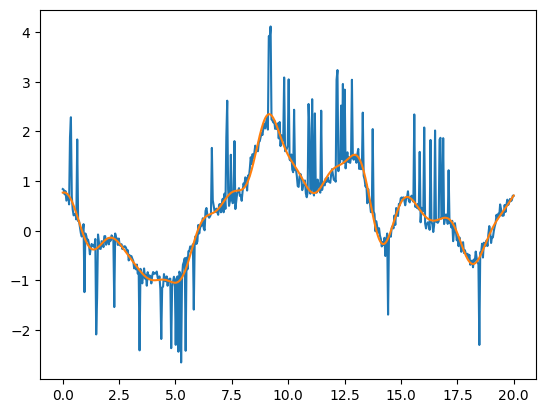

In [22]:
plt.plot(X,y)
plt.plot(X,model.mu_f)

TWIN ROBUST PROCESS

In [33]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance_1 = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale_1 = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c= tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance_2= tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale_2 = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

mean_loo_2=tf.zeros_like(y,dtype=tf.float64)
mean_loo_1=tf.zeros_like(y,dtype=tf.float64)
N = X.shape[0]
W_1=tf.eye(N,N,dtype=tf.float64)
W_2=tf.eye(N,N,dtype=tf.float64)
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(100):
    print(i)

    kernel_1 = tfp.math.psd_kernels.ExponentiatedQuadratic(variance_1, lengthscale_1)
    K_1 = kernel_1.matrix(X, X)
    K_plus_W_inv_1=tf.linalg.inv(K_1+W_2)
    K_plus_W_inv_y_1=K_plus_W_inv_1@(y-mean_loo_2)
    mean_loo_1=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_1)*(1/tf.linalg.diag_part(K_plus_W_inv_1))
    LOO_probs_1=(tf.squeeze(y)-mean_loo_1)
    with tf.GradientTape() as tape:
        #estimate Gpflow kernel.
        LOO_probs_1=1/(1+LOO_probs_1**2/c**2)
        #sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo_1)**2))
        W_1=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs_1)/LOO_probs_1)
        kernel_2 = tfp.math.psd_kernels.ExponentiatedQuadratic(variance_2, lengthscale_2)
        K_2 = kernel_2.matrix(X, X)
        K_plus_W_inv_2=tf.linalg.inv(K_2+W_1)
        K_plus_W_inv_y_2=K_plus_W_inv_2@y
        mean_loo_1=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_2)*(1/tf.linalg.diag_part(K_plus_W_inv_2))
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo_1)**2)
    grad = tape.gradient(loss, [c,variance_2, lengthscale_2])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c,variance_2, lengthscale_2]))
"""
    kernel_2 = tfp.math.psd_kernels.ExponentiatedQuadratic(variance_2, lengthscale_2)
    K_2 = kernel_2.matrix(X, X)
    K_plus_W_inv_2=tf.linalg.inv(K_2+W_1)
    K_plus_W_inv_y_2=K_plus_W_inv_2@(y-mean_loo_1)
    mean_loo_2=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_2)*(1/tf.linalg.diag_part(K_plus_W_inv_2))
    LOO_probs_2=(tf.squeeze(y)-mean_loo_2)
    with tf.GradientTape() as tape:
        #estimate Gpflow kernel.
        LOO_probs_2=1/(1+LOO_probs_2**2/c**2)
        #sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo_2)**2))
        W_2=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs_2)/LOO_probs_2)
        kernel_1= tfp.math.psd_kernels.ExponentiatedQuadratic(variance_1, lengthscale_1)
        K_1 = kernel_1.matrix(X, X)
        K_plus_W_inv_1=tf.linalg.inv(K_1+W_2)
        K_plus_W_inv_y_1=K_plus_W_inv_1@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_1)*(1/tf.linalg.diag_part(K_plus_W_inv_1))
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [c,variance_1, lengthscale_1])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c,variance_1, lengthscale_1]))
    
pred_loo=K@K_plus_W_inv_2@y+K@K_plus_W_inv_1@y
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


'\n    kernel_2 = tfp.math.psd_kernels.ExponentiatedQuadratic(variance_2, lengthscale_2)\n    K_2 = kernel_2.matrix(X, X)\n    K_plus_W_inv_2=tf.linalg.inv(K_2+W_1)\n    K_plus_W_inv_y_2=K_plus_W_inv_2@(y-mean_loo_1)\n    mean_loo_2=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_2)*(1/tf.linalg.diag_part(K_plus_W_inv_2))\n    LOO_probs_2=(tf.squeeze(y)-mean_loo_2)\n    with tf.GradientTape() as tape:\n        #estimate Gpflow kernel.\n        LOO_probs_2=1/(1+LOO_probs_2**2/c**2)\n        #sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo_2)**2))\n        W_2=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs_2)/LOO_probs_2)\n        kernel_1= tfp.math.psd_kernels.ExponentiatedQuadratic(variance_1, lengthscale_1)\n        K_1 = kernel_1.matrix(X, X)\n        K_plus_W_inv_1=tf.linalg.inv(K_1+W_2)\n        K_plus_W_inv_y_1=K_plus_W_inv_1@y\n        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y_1)*(1/tf.linalg.diag_part(K_plus_W_inv_1))\n        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)\

<tf.Tensor: shape=(200,), dtype=float64, numpy=
array([ 0.26381009,  0.33435176,  0.37790305,  0.10449033,  0.49568128,
        0.56824255,  0.63891802,  0.72736166,  0.80401601,  0.84071687,
        0.55943827,  0.56611361,  0.88748079,  0.84755058,  0.78695008,
        0.73646533,  0.69838902,  0.40761792,  0.6881414 ,  0.68994704,
        0.65526555,  0.61098118,  0.14673229,  0.39147806,  0.23798976,
        0.07100411, -0.13396989, -0.26284252, -0.37718625, -0.12095869,
       -0.43269621, -0.39537278, -0.33294192, -0.21424024, -0.1036944 ,
       -0.00151895,  0.08563544,  0.17843054,  0.26281   ,  0.32828156,
        0.3356591 ,  0.33631777,  0.29453333, -0.06343857,  0.06918158,
       -0.0996691 , -0.24402392,  0.00694365, -0.5584364 , -0.66748427,
       -0.75314272, -0.81779452, -0.87960666, -0.91212352, -0.50425512,
       -0.94907454, -0.92019267, -0.90865546, -0.90946813, -0.90332699,
       -0.94042984, -0.9570927 , -0.95687075, -0.65360685, -0.96434259,
       -0.895825

Here is the LOSS predictive with c defined based on a fixed proportion of outliers, and the loss being the expected MSE(mean+variance)

In [7]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    def maximize_c(y, quant):
        return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2+sigma_loo)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_01=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933068837>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999330216085>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3758110630027807>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866152477>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866045085>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821184977523133>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997992352427>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799067518>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821656842162389>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997323167997>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732088577>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3815027126309904>, <tf.Variable 'Variable:0' shape=() dtype=float

In [37]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
w_diag=tf.Variable([1.]*200, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        W=tf.linalg.diag(w_diag)*sigma**2
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        loss=tf.reduce_sum(abs(tf.squeeze(y)-mean_loo))
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
    grad = tape.gradient(loss, [w_diag,variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [w_diag,variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_matto=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.39900000701593613>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999324840124>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4401037261678518>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4000000003208559>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999865324287>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4378659184817382>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999362581734>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798164916>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.436608434217604>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999869307805>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.403999973100507>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.435502350239257>, <tf.Variable 'Variable:0' shape=() dtype=float64,

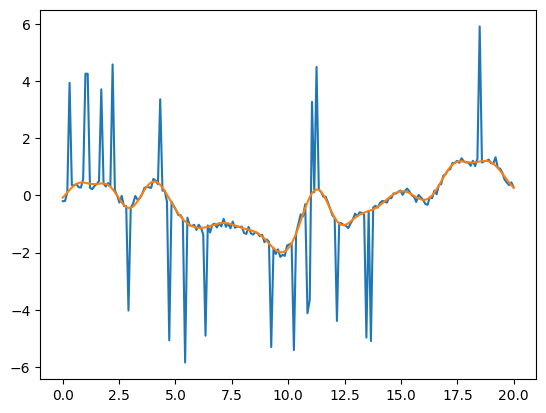

In [38]:
plt.plot(X,y)
plt.plot(X,pred_matto)



(array([2.82647139, 0.60031251, 0.25013021, 0.17509115, 0.22511719,
        0.20010417, 0.07503906, 0.12506511, 0.05002604, 0.4752474 ]),
 array([1.00000000e-03, 2.00895885e-01, 4.00791769e-01, 6.00687654e-01,
        8.00583539e-01, 1.00047942e+00, 1.20037531e+00, 1.40027119e+00,
        1.60016708e+00, 1.80006296e+00, 1.99995885e+00]),
 <BarContainer object of 10 artists>)

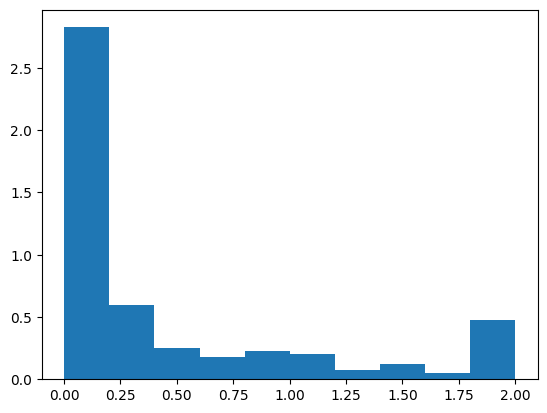

In [28]:
w1=w_diag.value()
plt.hist(w1,density=True)

In [41]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
w_diag=tf.Variable([1.]*200, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]

def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(10000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        W=tf.linalg.diag(w_diag)
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        loss=tf.reduce_sum(abs(tf.squeeze(y)-mean_loo))
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
    grad = tape.gradient(loss, [w_diag,variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [w_diag,variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_matto1=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3710663904700768>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.400999993286743>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999328024416>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3704186606252025>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998657335484>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998656041386>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.369776168730831>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798598339>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798405078>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3691388902692552>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997314617864>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997312052466>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3685068004098293>, <tf.Variable 'Variable:0' shape=() dtype=float

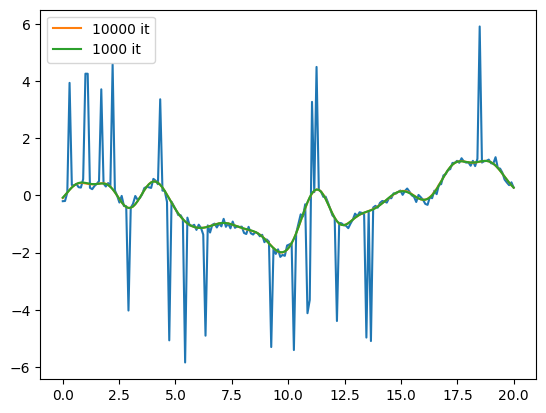

In [43]:

plt.plot(X,y)
plt.plot(X,pred_matto1,label="10000 it")
plt.plot(X,pred_matto,label="1000 it")
plt.legend()
plt.show()

(array([0.86224709, 0.1129841 , 0.13677023, 0.01783959, 0.01189306,
        0.01783959, 0.01783959, 0.        , 0.00594653, 0.00594653]),
 array([1.00000000e-03, 8.41826270e-01, 1.68265254e+00, 2.52347881e+00,
        3.36430508e+00, 4.20513135e+00, 5.04595762e+00, 5.88678389e+00,
        6.72761016e+00, 7.56843643e+00, 8.40926270e+00]),
 <BarContainer object of 10 artists>)

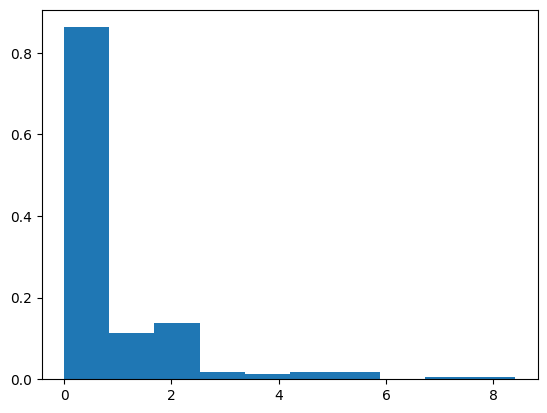

In [44]:
w1=w_diag.value()
plt.hist(w1,density=True)

<tf.Tensor: shape=(200,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, Fal

HERE WE MAXIMIZE THE MARGINAL

In [28]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    def maximize_c(y, quant):
        return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        vv = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros_like(mean_loo),K_plus_W_inv)
        loss=vv.log_prob(tf.squeeze(y))
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_marginalized=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933210772>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933165631>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3758110629936549>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998664216907>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998663315933>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821184977333862>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997996327563>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799497884>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821656841880667>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732843968>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732664501>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3815027125936898>, <tf.Variable 'Variable:0' shape=() dtype=float

Here is the LOSS predictive with c defined based on a fixed proportion of outliers, and the loss being the predictive loss


In [8]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    def maximize_c(y, quant):
        return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """ sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_cprop_MSE=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933107045>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999932982398>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3758110630020326>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998662231523>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999865967216>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.382118497750806>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799338618>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798950474>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.382165684214099>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.403999973245323>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319317105>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.381502712628232>, <tf.Variable 'Variable:0' shape=() dtype=float64, n

here we maximize with respect to c too

In [9]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c= tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    W=tf.eye(N,N,dtype=tf.float64)*sigma**2


    #W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)*sigma**2


    #W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)
        """

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [c,variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c,variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_cmax=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933115902>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999330326835>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.425533300338328>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998662466035>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998660458786>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4568195438471587>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997993749304>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997990533526>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4762406810113573>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997325018316>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732056331>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.483172913966044>, <tf.Variable 'Variable:0' shape=() dtype=floa

In [10]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    c=2*tf.sqrt(sigma_loo)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_c_2sigma=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933034099>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933041395>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.5297932913726742>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866113323>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998660203184>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3710805326287465>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799231108>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997990027847>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3846212861798468>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997323394254>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319850417>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.376616068633675>, <tf.Variable 'Variable:0' shape=() dtype=float

Here we use the LOO probability as weight.

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933122082>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999932984756>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866247731>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999865976474>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799375334>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798972427>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732504087>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319710373>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.

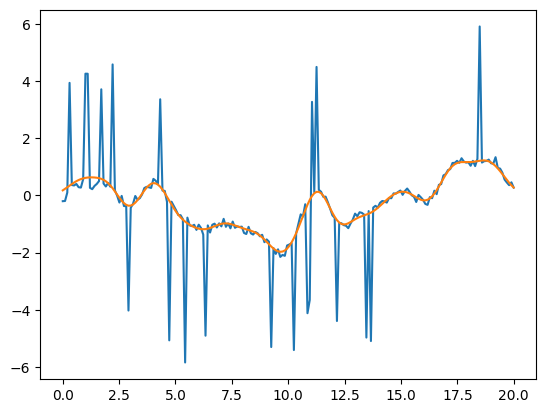

In [11]:
sigma = tf.Variable(1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W = tf.eye(N, N, dtype=tf.float64) * sigma ** 2


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv = tf.linalg.inv(K + W)
    K_plus_W_inv_y = K_plus_W_inv @ y
    mean_loo = tf.squeeze(y) - tf.squeeze(K_plus_W_inv_y) * (1 / tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo = 1 / tf.linalg.diag_part(K_plus_W_inv)
    vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    LOO_probs=tf.exp(LOO_probs)/tf.reduce_mean(tf.exp(LOO_probs))

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        W = tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs) / LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv = tf.linalg.inv(K + W)
        K_plus_W_inv_y = K_plus_W_inv @ y
        mean_loo = tf.squeeze(y) - tf.squeeze(K_plus_W_inv_y) * (1 / tf.linalg.diag_part(K_plus_W_inv))
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [ variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print([sigma, variance, lengthscale])
pred_LOO_margprob = K @ K_plus_W_inv @ y
plt.plot(X,y)
plt.plot(X,pred_LOO_margprob)

In [12]:
#variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
#lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
#const_22=8
for i in range(50):
    print(i)

    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*8
        
        mu_f = tf.zeros_like(tf.squeeze(y), dtype=tf.float64)
        Sigma_f= tf.linalg.inv(K+W)
# Multivariate normal distribution
        vv = tfp.distributions.MultivariateNormalFullCovariance(loc=mu_f, covariance_matrix=Sigma_f)

# Compute log-probability and return a scalar
        loss = tf.reduce_sum(vv.log_prob(tf.squeeze(y)))

    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
    mu_alpha=update_mu_alpha(mu_f,tf.linalg.diag_part(Sigma_f),y)
K = kernel.matrix(X, X)
W=tf.linalg.diag(mu_alpha_inv)
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_marginal=K@K_plus_W_inv@y

0
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.3999931343955994>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6480453747283839>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.400993127719253>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.649045368051882>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4019931210429075>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6500453613753823>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4029931143665633>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6510453546988823>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.40399310769022>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6520453480223832>]
5
[<tf.Variable 'Variable:0' shape=() dtype=f

In [13]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t)*8
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        loss=tf.reduce_sum((Y_test-mu_f_pred)**2)
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f= tf.linalg.inv(K+W)
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
    mu_alpha=update_mu_alpha(mu_f,tf.linalg.diag_part(Sigma_f),y)
    
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_loss=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999321225593>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999308786755>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999863930078>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998608779297>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997948219024>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997879894384>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997272343113>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999719215712>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999659439457>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999650261137>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40599995914507603>, <

In [14]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y,b_squared):
    diff=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/b_squared
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y,b_squared):
    diff=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/b_squared
    return (1/diff)**0.5
    
b_squared=1.
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t*b_squared)
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        loss=tf.reduce_sum(abs(Y_test-mu_f_pred))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f=tf.linalg.inv(K+W)
    b_squared=tf.reduce_mean(tf.squeeze(y-mu_f)**2+tf.linalg.diag_part(Sigma_f)*mu_alpha_inv)
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y,b_squared)

    
K = kernel.matrix(X, X)  
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_absLoss=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999292763977>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999307952455>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998615799454>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998617682925>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999793646803>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999792671175>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999725781457>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997235360724>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999658102966>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999654686433>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4059999590413969>, <tf

In [15]:
print(tf.reduce_mean((f-pred_lap_absLoss)**2),tf.reduce_mean(abs(f-pred_lap_absLoss)),"Laplace absloss")

tf.Tensor(0.013918001836459757, shape=(), dtype=float64) tf.Tensor(0.09941322722155789, shape=(), dtype=float64) Laplace absloss


In [16]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
@tf.function
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*8
        K_plus_W_inv=tf.linalg.inv(K+W)
        mu_f=K@K_plus_W_inv@y
        Sigma_f=tf.linalg.inv(K+W)
        mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
        
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t)*8
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        """sigma_f_pred=K_star_star-tf.transpose(K_star) @tf.linalg.inv(K+W)@K_star
        vv = tfp.distributions.MultivariateNormalFullCovariance(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(tf.squeeze(Y_test))
        """
        loss=tf.reduce_sum(abs(Y_test-mu_f_pred))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    

    
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_absloss_trackalpha=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999319698193>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999930678536>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999863887017>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999861200811>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999795706369>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997911834184>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997276019806>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999721463957>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996596028487>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996519002884>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40599995916334913>, <t

In [17]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

alpha=tf.constant(0.5,dtype=tf.float64)
k_11=tf.constant((1-2*alpha)/(alpha*(1-alpha)),dtype=tf.float64)
k_22=tf.constant(2/(alpha*(1-alpha)),dtype=tf.float64)
N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)
b_squared=1.

def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def update_mu_alpha_inv(mu_f,sigma_f_diag,y,b_squared):
    diff_1=(4+k_11**2)/b_squared
    diff_2=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/(b_squared)
    return (diff_1/diff_2)**0.5
    
for i in range(300):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        
        #estimate Gpflow kernel.
        
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
        
        vv = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros_like(mu_alpha_inv),tf.linalg.inv(K+W))
        loss = vv.log_prob(tf.squeeze((y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f=tf.linalg.inv(K+W)
    b_squared=tf.reduce_mean((tf.squeeze(y-mu_f)**2+tf.linalg.diag_part(Sigma_f))*mu_alpha_inv)+tf.reduce_mean((k_11**2+4)/(mu_alpha_inv))
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y,b_squared)
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*b_squared
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_marginal_new=K@K_plus_W_inv@(y-k_11*1/tf.reshape(mu_alpha_inv, (-1, 1)))

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999332107683>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999331656394>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866422386>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866330444>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799633837>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799495971>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732845575>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732661612>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.404999966605736>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.404999966582771>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40599995992693316>, <tf.Var

In [18]:

from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast

import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye


from typing import Any, Callable
import tensorflow as tf
from check_shapes import check_shapes

from gpflow.base import TensorType
from gpflow.likelihoods import Gaussian


def assert_params_false(
    called_method: Callable[..., Any],
    **kwargs: bool,
) -> None:

    errors_str = ", ".join(f"{param}={value}" for param, value in kwargs.items() if value)
    if errors_str:
        raise NotImplementedError(
            f"{called_method.__qualname__} does not currently support: {errors_str}"
        )


def add_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood_variance: TensorType) -> tf.Tensor:

    k_diag = tf.linalg.diag_part(K)
    return tf.linalg.set_diag(K, k_diag + likelihood_variance*(W**-2))


def add_likelihood_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood: Gaussian, X: TensorType) -> tf.Tensor:
    W_squeeze = tf.squeeze(W, axis=-1)
    variance_squeeze = tf.squeeze(likelihood.variance_at(X), axis=-1)
    return add_noise_cov(K, W_squeeze, variance_squeeze)



class RCGPR_deprecated(GPModel, InternalDataTrainingLossMixin):
    """
    Robust and Conjugate Gaussian Process Regression
    This method only works with a Gaussian likelihood, its variance is
    initialized to `noise_variance`.
    """
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, P]",
        "noise_variance: []",
    )
    def __init__(
        self,
        data: RegressionData,
        kernel: Kernel,
        weighting_function,
        mean_function: Optional[MeanFunction] = None,
        noise_variance: Optional[TensorData] = None,
        likelihood: Optional[Gaussian] = None,
    ):
        assert (noise_variance is None) or (
            likelihood is None
        ), "Cannot set both `noise_variance` and `likelihood`."
        if likelihood is None:
            if noise_variance is None:
                noise_variance = 1.0
            likelihood = gpflow.likelihoods.Gaussian(noise_variance)
        _, Y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent_gps=Y_data.shape[-1])
        self.data = data_input_to_tensor(data)
        self.weighting_function = weighting_function

    @inherit_check_shapes
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.loo_cv()

    @check_shapes(
        "return: []",
    )
    def log_marginal_likelihood(self) -> tf.Tensor:
        r"""
        Computes the log pseudo smarginal likelihood.

        """
        X, Y = self.data
        n = tf.shape(X)[0]
        K = self.kernel(X)
        W = self.weighting_function.W(X, Y)
        W_dy = self.weighting_function.dy(X, Y)

        K_plus_sW = add_likelihood_noise_cov(K, W, self.likelihood, X)
        L_plus_sW = tf.linalg.cholesky(K_plus_sW + tf.eye(n, dtype=default_float()) * 1e-04)

        nu = (self.likelihood.variance_at(X)**-1)*Y*(W**2)-2*W*W_dy

        A = tf.linalg.triangular_solve(L_plus_sW, tf.transpose(tf.linalg.matmul(nu, K, transpose_a=True)), lower=True)
        B = tf.linalg.triangular_solve(L_plus_sW, nu*(W**-2)*self.likelihood.variance_at(X), lower=True)

        C1 = tf.matmul(Y, Y*(W**2)*self.likelihood.variance_at(X)**-1, transpose_a=True)/2
        C2 = - tf.matmul(Y, W*W_dy, transpose_a=True)
        C3 = - tf.matmul(W, W, transpose_a=True)

        C = tf.reduce_sum(C1+C2+C3)

        D1 = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_plus_sW)))
        D2 = tf.reduce_sum(tf.math.log((W**2)*self.likelihood.variance_at(X)**-1))/2

        D = tf.reduce_sum(D1+D2) 

        return tf.reduce_sum(tf.linalg.matmul(A, B, transpose_a=True))/2 - C - D

    def loo_cv(self) -> tf.Tensor:
        r"""
        Computes the leave one out to train the model
        """
        X, Y = self.data
        err = Y - self.mean_function(X)
        K = self.kernel(X)
        n = tf.cast(tf.shape(X)[0], K.dtype)
        likelihood_variance = self.likelihood.variance_at(X)
        W, W_dy = self.weighting_function.w_dy(X, err)
        dylog2 = 2*likelihood_variance*W_dy/W
        Y_bar = err - dylog2

        K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
        L_sW = tf.linalg.cholesky(K_sW)
        L_sW_inv = tf.linalg.inv(L_sW)

        #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

        #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
        diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv**2, axis=0), (-1, 1))

        A = diag_K_sW_inv*dylog2
        
        #B = tf.matmul(K_sW_inv, Y_bar)
        B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
        C = diag_K_sW_inv * (1-diag_K_sW_inv*(likelihood_variance*(W**-2) - likelihood_variance))

        D = C/diag_K_sW_inv**2

        loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
        loo -= 0.5 * n * np.log(2 * np.pi)
        loo -= 0.5 * tf.reduce_sum((A+B)**2/C)
        return loo

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        
        X, Y = self.data
        err = Y - self.mean_function(X)
        m = tf.shape(X)[0]

        W = self.weighting_function.W(X, err)
        W_dy = self.weighting_function.dy(X, err)

        likelihood_variance = self.likelihood.variance_at(X)

        kmm = self.kernel(X)
        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(X, Xnew)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X)

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW
                                        + tf.eye(m, dtype=default_float())
                                        * 1e-06)

        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        f = err - 2*likelihood_variance*W_dy/W
        B = tf.linalg.triangular_solve(Lm_plus_sW, f, lower=True)  # [..., W, N]
        f_mean_zero = tf.linalg.matmul(A, B, transpose_a=True)

        f_mean = f_mean_zero + self.mean_function(Xnew)

        return f_mean, f_var


class RCGPR_with_posterior(RCGPR_deprecated):
    """
    This is an implementation of GPR that provides a posterior() method that
    enables caching for faster subsequent predictions.
    """

    def posterior(
        self,
        precompute_cache: posteriors.PrecomputeCacheType = posteriors.PrecomputeCacheType.TENSOR,
    ):
        """
        Create the Posterior object which contains precomputed matrices for
        faster prediction.

        precompute_cache has three settings:

        - `PrecomputeCacheType.TENSOR` (or `"tensor"`): Precomputes the cached
          quantities and stores them as tensors (which allows differentiating
          through the prediction). This is the default.
        - `PrecomputeCacheType.VARIABLE` (or `"variable"`): Precomputes the cached
          quantities and stores them as variables, which allows for updating
          their values without changing the compute graph (relevant for AOT
          compilation).
        - `PrecomputeCacheType.NOCACHE` (or `"nocache"` or `None`): Avoids
          immediate cache computation. This is useful for avoiding extraneous
          computations when you only want to call the posterior's
          `fused_predict_f` method.
        """

        return RCGPPosterior(
            kernel=self.kernel,
            data=self.data,
            weighting_function=self.weighting_function,
            likelihood=self.likelihood,
            mean_function=self.mean_function,
            precompute_cache=precompute_cache,
        )

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        For backwards compatibility, GPR's predict_f uses the fused (no-cache)
        computation, which is more efficient during training.

        For faster (cached) prediction, predict directly from the posterior object, i.e.,:
            model.posterior().predict_f(Xnew, ...)
        """
        return self.posterior(posteriors.PrecomputeCacheType.NOCACHE).fused_predict_f(
            Xnew, full_cov=full_cov, full_output_cov=full_output_cov
        )


class RCGPPosterior(posteriors.AbstractPosterior):
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, Q]",
    )
    def __init__(
        self,
        kernel: Kernel,
        data: RegressionData,
        weighting_function,
        likelihood: Gaussian,
        mean_function: MeanFunction,
        *,
        precompute_cache: Optional[posteriors.PrecomputeCacheType],
    ) -> None:
        X, Y = data
        super().__init__(kernel, X, mean_function=mean_function)
        self.Y_data = Y
        self.likelihood = likelihood
        self.weighting_function = weighting_function

        if precompute_cache is not None:
            self.update_cache(precompute_cache)

    @inherit_check_shapes
    def _conditional_with_precompute(
        self,
        cache: Tuple[tf.Tensor, ...],
        Xnew,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function.
        Relies on cached alpha and Qinv.
        """
        err, Lm_plus_sW, W, W_dy, likelihood_variance = cache

        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(self.X_data, Xnew)


        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]
        M = tf.shape(err)[-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        A = tf.linalg.triangular_solve(tf.linalg.adjoint(Lm_plus_sW), A, lower=False)
  
        f = err - 2*likelihood_variance*W_dy/W
        f_shape = tf.concat([leading_dims, [M, num_func]], 0)  # [..., M, R]
        f = tf.broadcast_to(f, f_shape)

        f_mean = tf.linalg.matmul(A, f, transpose_a=True)

        return f_mean, f_var

    def _precompute(self) -> Tuple[posteriors.PrecomputedValue, ...]:
        assert self.mean_function is not None
        X_data = cast(tf.Tensor, self.X_data)
        err = self.Y_data - self.mean_function(X_data)
        
        D = err.shape[1]
        M = X_data.shape[0]
        D_dynamic = D is None
        M_dynamic = M is None

        W = self.weighting_function.W(X_data, err)
        W_dy = self.weighting_function.dy(X_data, err)

        likelihood_variance = self.likelihood.variance_at(self.X_data)

        kmm = self.kernel(X_data)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X_data) + eye(
            tf.shape(X_data)[-2], value=default_jitter(), dtype=default_float()
        )

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW)

        return (
            posteriors.PrecomputedValue(err, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(Lm_plus_sW, (M_dynamic, M_dynamic)),
            posteriors.PrecomputedValue(W, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(W_dy, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(likelihood_variance, (M_dynamic, D_dynamic)),
        )

    @inherit_check_shapes
    def _conditional_fused(
        self, Xnew, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function
        Does not make use of caching
        """
        temp_cache = tuple(c.value for c in self._precompute())
        return self._conditional_with_precompute(temp_cache, Xnew, full_cov, full_output_cov)


class RCGPR(RCGPR_with_posterior):
    __doc__ = RCGPR_deprecated.__doc__ 


In [19]:
model = RCGPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential(),
    weighting_function= w.IMQ(1),
    noise_variance=standard_gp.likelihood.variance)

In [20]:
gpflow.set_trainable(model.likelihood.variance, True)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
gpflow.utilities.print_summary(model, "notebook")

f_mean_dsm, f_var_dsm = model.predict_f(X, full_cov=False)

In [29]:
print(tf.reduce_mean((f_mean_dsm-f)**2),tf.reduce_mean(abs(f-f_mean_dsm)),"rcgp mean")
print(tf.reduce_mean((f-f_mean)**2),tf.reduce_mean(abs(f-f_mean)),"normal mean")
print(tf.reduce_mean((f-pred_LOO_cprop_MSE)**2),tf.reduce_mean(abs(f-pred_LOO_cprop_MSE)),"pred_LOO_cprop_MSE")
print(tf.reduce_mean((f-pred_marginalized)**2),tf.reduce_mean(abs(f-pred_marginalized)),"pred_LOO_cprop_marginalizedloss")
print(tf.reduce_mean((f-pred_LOO_cmax)**2),tf.reduce_mean(abs(f-pred_LOO_cmax)),"pred_LOO_c maximized")
print(tf.reduce_mean((f-pred_LOO_c_2sigma)**2),tf.reduce_mean(abs(f-pred_LOO_c_2sigma)),"pred_LOO_ c =2*sigma")
print(tf.reduce_mean((f-pred_LOO_margprob)**2),tf.reduce_mean(abs(f-pred_LOO_margprob)),"pred_LOO_ weights given by marginal prob")
print(tf.reduce_mean((f-Mu_full)**2),tf.reduce_mean(abs(f-Mu_full)),"rcgp_alpha mean")
print(tf.reduce_mean((f-pred_01)**2),tf.reduce_mean(abs(f-pred_01)),"LOO_cprop_MSE+VAr")
print(tf.reduce_mean((f-pred_lap_loss)**2),tf.reduce_mean(abs(f-pred_lap_loss)),"laplace mse")
print(tf.reduce_mean((f-pred_lap_marginal)**2),tf.reduce_mean(abs(f-pred_lap_marginal)),"Laplace Marginal ")
print(tf.reduce_mean((f-pred_lap_marginal_new)**2),tf.reduce_mean(abs(f-pred_lap_marginal_new)),"Laplace Marginal new")
print(tf.reduce_mean((f-pred_lap_absLoss)**2),tf.reduce_mean(abs(f-pred_lap_absLoss)),"Laplace absloss")
print(tf.reduce_mean((f-pred_lap_absloss_trackalpha)**2),tf.reduce_mean(abs(f-pred_lap_absloss_trackalpha)),"Laplace absloss+track")

tf.Tensor(0.22498506960267228, shape=(), dtype=float64) tf.Tensor(0.4322596205037398, shape=(), dtype=float64) rcgp mean
tf.Tensor(0.2128135237527253, shape=(), dtype=float64) tf.Tensor(0.3607827732709825, shape=(), dtype=float64) normal mean
tf.Tensor(0.02812626810078979, shape=(), dtype=float64) tf.Tensor(0.12494837517477098, shape=(), dtype=float64) pred_LOO_cprop_MSE
tf.Tensor(0.05041868099329538, shape=(), dtype=float64) tf.Tensor(0.1768489016922115, shape=(), dtype=float64) pred_LOO_cprop_marginalizedloss
tf.Tensor(0.0027064482057216044, shape=(), dtype=float64) tf.Tensor(0.04488325412265159, shape=(), dtype=float64) pred_LOO_c maximized
tf.Tensor(0.03423028469386283, shape=(), dtype=float64) tf.Tensor(0.13755590635591056, shape=(), dtype=float64) pred_LOO_ c =2*sigma
tf.Tensor(0.008135160120363439, shape=(), dtype=float64) tf.Tensor(0.0674416058989617, shape=(), dtype=float64) pred_LOO_ weights given by marginal prob
tf.Tensor(0.032801923460654345, shape=(), dtype=float64) tf.Te

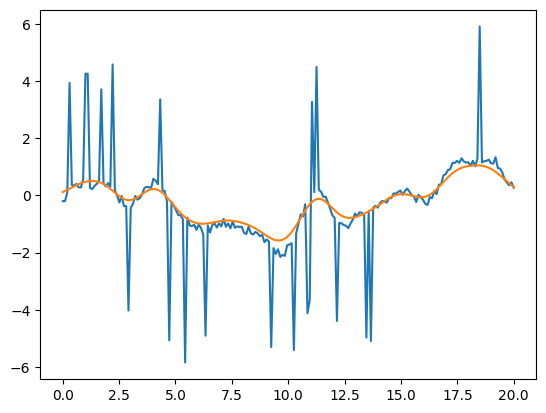

In [26]:
plt.plot(X,y)
plt.plot(X,pred_lap_marginal_new)

In [52]:
c

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0920002301553122>